<a href="https://colab.research.google.com/github/MaliheDahmardeh/state-house-price-analysis-SM/blob/main/state-house-price-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Brief description of the dataset
This dataset provides information about the mean home prices across a number of US states and housing types
collected in the period from 30th April 1996 to 31st December 2017 (monthly data). The data are available for 44
states and different house types, in particular 1/2/3/4/5+ bedrooms and single family residence.
#Project steps
The main aim of this project is to perform house price forecasting for the last two years (2016/2017), whose data
should be used as testing set.
Following what we have seen in the laboratory classes, a comprehensive pipeline should be devised, including in
particular:
1. Loading, converting and cleaning of the data;
2. Exploring the dataset with descriptive statistics and (possibly) frequency analysis. Use appropriate graphs to
visualise the data at hand;
3. Focusing on few US states and housing types, describing the time series patterns (visually and numerically);
4. Choosing the appropriate model/models to forecast the data for the specified period for each selected
state/house type. Evaluate the model performance using different metrics. Visualise the results with
appropriate graphs.


#Import

In [2]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 34.2 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [3]:
import numpy as np
import pandas as pd
from datetime import datetime
from dateutil import parser
import math
import statistics
from statistics import median
from fractions import Fraction as fr
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
import plotly.express as px
from scipy import stats,signal
from scipy.stats import chi2, chi2_contingency
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.stats.stattools import durbin_watson

In [4]:
from pmdarima.preprocessing import FourierFeaturizer
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA

#Dataset Loading ...

In [5]:
!ls

sample_data  State_house_prices_ts.csv


In [6]:
df = pd.read_csv('State_house_prices_ts.csv', sep =',',parse_dates=['Date']).sort_values(by='Date', ascending=True , inplace=False)

In [7]:
display(df)
display(type(df))
display(df.dtypes)

,Date,RegionName,Price_1bedroom,Price_2bedroom,Price_3bedroom,Price_4bedroom,Price_5BedroomOrMore,Price_SingleFamilyResidence
1997,1996-04-30,Illinois,83800.0,92000.0,109300.0,171700.0,224000.0,116000.0
2006,1996-04-30,Michigan,66600.0,76900.0,98200.0,170200.0,166500.0,85400.0
2005,1996-04-30,Massachusetts,82900.0,106600.0,136300.0,195400.0,249200.0,144300.0
2003,1996-04-30,Maine,NaN,79000.0,91500.0,112600.0,135100.0,88300.0
2002,1996-04-30,Louisiana,NaN,NaN,76400.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
12988,2017-12-31,Maryland,160400.0,193400.0,251300.0,378700.0,507700.0,285000.0
12989,2017-12-31,Massachusetts,289300.0,301000.0,368300.0,519100.0,720900.0,392900.0
12990,2017-12-31,Michigan,101700.0,118800.0,158500.0,282900.0,294100.0,134800.0
12992,2017-12-31,Mississippi,NaN,NaN,124100.0,221000.0,250400.0,118500.0


pandas.core.frame.DataFrame

Date                           datetime64[ns]
RegionName                             object
Price_1bedroom                        float64
Price_2bedroom                        float64
Price_3bedroom                        float64
Price_4bedroom                        float64
Price_5BedroomOrMore                  float64
Price_SingleFamilyResidence           float64
dtype: object

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13212 entries, 1997 to 13006
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Date                         13212 non-null  datetime64[ns]
 1   RegionName                   13212 non-null  object        
 2   Price_1bedroom               10605 non-null  float64       
 3   Price_2bedroom               11745 non-null  float64       
 4   Price_3bedroom               12787 non-null  float64       
 5   Price_4bedroom               12359 non-null  float64       
 6   Price_5BedroomOrMore         11814 non-null  float64       
 7   Price_SingleFamilyResidence  12438 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 929.0+ KB


#Data Cleaning

In [9]:
#check the column , index and values in the dataframe
print('columns:', df.columns)
print('')
print('indexes:', df.index)
print('')
print('values:', df.values)

columns: Index(['Date', 'RegionName', 'Price_1bedroom', 'Price_2bedroom',
       'Price_3bedroom', 'Price_4bedroom', 'Price_5BedroomOrMore',
       'Price_SingleFamilyResidence'],
      dtype='object')

indexes: Int64Index([ 1997,  2006,  2005,  2003,  2002,  2001,  2000,  1999,  1998,
             1996,
            ...
            12983, 12984, 12985, 12986, 12987, 12988, 12989, 12990, 12992,
            13006],
           dtype='int64', length=13212)

values: [[Timestamp('1996-04-30 00:00:00') 'Illinois' 83800.0 ... 171700.0
  224000.0 116000.0]
 [Timestamp('1996-04-30 00:00:00') 'Michigan' 66600.0 ... 170200.0
  166500.0 85400.0]
 [Timestamp('1996-04-30 00:00:00') 'Massachusetts' 82900.0 ... 195400.0
  249200.0 144300.0]
 ...
 [Timestamp('2017-12-31 00:00:00') 'Michigan' 101700.0 ... 282900.0
  294100.0 134800.0]
 [Timestamp('2017-12-31 00:00:00') 'Mississippi' nan ... 221000.0
  250400.0 118500.0]
 [Timestamp('2017-12-31 00:00:00') 'Pennsylvania' 118800.0 ... 292100.0
  307000.0 16

In [10]:
#name and number of states in the data set 
print('Total number of States :',df['RegionName'].nunique())
print('-------------')
print('Name of the States :',df['RegionName'].unique(),sep='\n')

Total number of States : 52
-------------
Name of the States :
['Illinois' 'Michigan' 'Massachusetts' 'Maine' 'Louisiana' 'Kentucky'
 'Kansas' 'Iowa' 'Indiana' 'Idaho' 'Hawaii' 'Georgia' 'Florida' 'Delaware'
 'Connecticut' 'Colorado' 'California' 'Arkansas' 'Arizona' 'Alabama'
 'Minnesota' 'Mississippi' 'Maryland' 'Nebraska' 'Wisconsin'
 'WestVirginia' 'Washington' 'Virginia' 'Utah' 'Texas' 'Missouri'
 'SouthCarolina' 'RhodeIsland' 'Pennsylvania' 'Tennessee' 'Nevada'
 'Oklahoma' 'Ohio' 'NorthCarolina' 'NewYork' 'NewMexico' 'NewJersey'
 'NewHampshire' 'Oregon' 'Vermont' 'SouthDakota' 'Alaska' 'Montana'
 'Wyoming' 'DistrictofColumbia' 'NorthDakota' 'UnitedStates']


In [11]:
#check for duplicated rows/values
df.duplicated().sum()  

0

In [12]:
#check the number of null values for each column
df.isnull().sum()

Date                              0
RegionName                        0
Price_1bedroom                 2607
Price_2bedroom                 1467
Price_3bedroom                  425
Price_4bedroom                  853
Price_5BedroomOrMore           1398
Price_SingleFamilyResidence     774
dtype: int64

In [13]:
#check the states that have empty/null row 
a=df.loc[df.isnull().sum(axis=1) > 5]
a.groupby('RegionName').nunique()

,Date,Price_1bedroom,Price_2bedroom,Price_3bedroom,Price_4bedroom,Price_5BedroomOrMore,Price_SingleFamilyResidence
RegionName,,,,,,,
Alaska,10,0,0,0,0,0,0
DistrictofColumbia,10,0,0,0,0,0,0
Kansas,64,0,0,0,0,0,0
UnitedStates,95,0,0,0,0,0,0


In [14]:
# drop the states that have lots of null values and specially drop states with the completely empty column(house price column)
df=df[(df.RegionName != 'UnitedStates')]
df=df[(df.RegionName != 'Kansas')]
df=df[(df.RegionName != 'DistrictofColumbia')]
df=df[(df.RegionName != 'NewYork')]
df=df[(df.RegionName != 'Wyoming')]
df=df[(df.RegionName != 'NorthDakota')]
df=df[(df.RegionName != 'Texas')]
df=df[(df.RegionName != 'Louisiana')]
df=df[(df.RegionName != 'Utah')]
df=df[(df.RegionName != 'Vermont')]
df=df[(df.RegionName != 'WestVirginia')]
df=df[(df.RegionName != 'SouthCarolina')]
df=df[(df.RegionName != 'NewMexico')]
df=df[(df.RegionName != 'Mississippi')]
df=df[(df.RegionName != 'Nevada')]

In [15]:
df.isnull().sum()

Date                             0
RegionName                       0
Price_1bedroom                  80
Price_2bedroom                  10
Price_3bedroom                  26
Price_4bedroom                  90
Price_5BedroomOrMore           198
Price_SingleFamilyResidence     26
dtype: int64

In [16]:
#also there is missing states by dates, we will fix it after pivot table
rc=df.groupby('Date')['RegionName'].count()
rc

Date
1996-04-30    34
1996-05-31    35
1996-06-30    35
1996-07-31    35
1996-08-31    35
              ..
2017-08-31    37
2017-09-30    37
2017-10-31    37
2017-11-30    37
2017-12-31    37
Name: RegionName, Length: 261, dtype: int64

In [17]:
#use median of each state for filling its null values 
num_cols = df.select_dtypes(exclude='object').columns
df[num_cols] = df.groupby(['RegionName'])[num_cols].apply(lambda x:x.fillna(x.median()))

display(df)
display(type(df))
display(df.dtypes)

<ipython-input-17-83b9982dc099>:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df[num_cols] = df.groupby(['RegionName'])[num_cols].apply(lambda x:x.fillna(x.median()))
<ipython-input-17-83b9982dc099>:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df[num_cols] = df.groupby(['RegionName'])[num_cols].apply(lambda x:x.fillna(x.median()))
<ipython-input-17-83b9982dc099>:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df[num_cols] = df.groupby(['RegionName'])[num_cols].apply(lambda x:x.fillna(x.median()))
<ipython-input-17-83b9982dc099>:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df[num_co

,Date,RegionName,Price_1bedroom,Price_2bedroom,Price_3bedroom,Price_4bedroom,Price_5BedroomOrMore,Price_SingleFamilyResidence
1997,1996-04-30,Illinois,83800.0,92000.0,109300.0,171700.0,224000.0,116000.0
2006,1996-04-30,Michigan,66600.0,76900.0,98200.0,170200.0,166500.0,85400.0
2005,1996-04-30,Massachusetts,82900.0,106600.0,136300.0,195400.0,249200.0,144300.0
2003,1996-04-30,Maine,156000.0,79000.0,91500.0,112600.0,135100.0,88300.0
2001,1996-04-30,Kentucky,49300.0,64600.0,78600.0,126800.0,151100.0,74400.0
...,...,...,...,...,...,...,...,...
12987,2017-12-31,Maine,180000.0,206500.0,240300.0,298800.0,372400.0,215500.0
12988,2017-12-31,Maryland,160400.0,193400.0,251300.0,378700.0,507700.0,285000.0
12989,2017-12-31,Massachusetts,289300.0,301000.0,368300.0,519100.0,720900.0,392900.0
12990,2017-12-31,Michigan,101700.0,118800.0,158500.0,282900.0,294100.0,134800.0


pandas.core.frame.DataFrame

Date                           datetime64[ns]
RegionName                             object
Price_1bedroom                        float64
Price_2bedroom                        float64
Price_3bedroom                        float64
Price_4bedroom                        float64
Price_5BedroomOrMore                  float64
Price_SingleFamilyResidence           float64
dtype: object

In [18]:
df.isnull().sum()

Date                           0
RegionName                     0
Price_1bedroom                 0
Price_2bedroom                 0
Price_3bedroom                 0
Price_4bedroom                 0
Price_5BedroomOrMore           0
Price_SingleFamilyResidence    0
dtype: int64

#Functions

In [19]:
def checkAutorcorrelation(resid, lags=36, return_data=False):
    import pandas as pd
    import statsmodels.formula.api as smf
    import statsmodels.api as sm
    import statsmodels.stats.diagnostic as dg
    
    #Ljung-Box
    lb_result = sm.stats.acorr_ljungbox(resid, lags=[lags], return_df=False)
    print("*** Ljung-Box Test [{} lags] ***".format(lags))
    print('Q: ', lb_result[0][0])
    print('p-value: ' , lb_result[1][0])
    if lb_result[1][0]>.05:
        print('Interpretation: the residuals are independently distributed (Ho)')
    else:
        print('Interpretation: The residuals are not independently distributed, they exhibit serial correlation (Ha)')
    
    #Breusch-Godfrey
    resid = pd.DataFrame(resid, columns=['resid'])
    resid['step'] = range(len(resid))
    fit = smf.ols('resid ~ step', data=resid).fit()
    bg_result = dg.acorr_breusch_godfrey(fit, nlags=lags)
    print('\n*** Breusch-Godfrey Test [{} lags] ***'.format(lags))
    print('Lagrange multiplier statistic: ', bg_result[0])
    print('p-value: ', bg_result[1])
    if bg_result[1]>.05:
        print('Interpretation: there is no autocorrelation at any order less than or equal to p (Ho)')
    else:
        print('Interpretation: There exists autocorrelation at some order less than or equal to p (Ha)')
    
    if return_data==True:
        return (lb_result[0][0], lb_result[1][0], bg_result[0], bg_result[1])

In [20]:
def checkNormality(data, return_data=False):
    from scipy.stats import shapiro, jarque_bera, normaltest, skew, kurtosis
    
    #Shapiro-Wilk
    w, p_w = shapiro(data)
    print('*** Shapiro-Wilk Test ***')
    print('W: ', w)
    print('p-value: ' , p_w)
    if p_w > .05:
        print('Interpretation: the data was drawn from a normal distribution (Ho)')
    else:
        print('Interpretation: the data was not drawn from a normal distribution (Ha)')
    
    #Jarque-Bera
    jb, p_jb = jarque_bera(data)
    print('\n*** Jarque-Bera Test ***')
    print('Jarque-Bera JB: ', jb)
    print('p-value: ' , p_jb)
    if p_jb > .05:
        print('Interpretation: the data was drawn from a normal distribution (Ho)')
    else:
        print('Interpretation: the data was not drawn from a normal distribution (Ha)')
    
    #D’Agostino-Pearson
    k2, p_k2 = normaltest(data)
    print("\n*** D’Agostino-Pearson Test ***")
    print('k2: ', k2)
    print('p-value: ' , p_k2)
    if p_k2 > .05:
        print('Interpretation: the data was drawn from a normal distribution (Ho)')
    else:
        print('Interpretation: the data was not drawn from a normal distribution (Ha)')

    print('\n----------------------------------------------------------------------')
    print('Skewness: ', skew(data))
    print('Kurtosis : ', kurtosis(data))
    
    if return_data==True:
        return (w, p_w, jb, p_jb, k2, p_k2)

In [21]:
def checkStationarity(data, kpss_type = 'ct', return_data=False, ci=.95):
    alpha = 1-ci
    
    if kpss_type in ['c','ct']:
        import warnings
        warnings.filterwarnings('ignore')
        from statsmodels.tsa.stattools import adfuller
        from statsmodels.tsa.stattools import kpss

        adf_test = adfuller(data,autolag='AIC')
        print('*** ADF Test ***')
        print('ADF Statistic: ', adf_test[0])
        print('p-value: ', adf_test[1])
        if adf_test[1] > alpha:
            print('Interpretation: The time series is non-stationary (Ho)')
        else:
            print('Interpretation: The time series is stationary (Ha)')

        kpss_test = kpss(data, regression=kpss_type)
        print('\n*** KPSS Test ***')
        print('KPSS Statistic:', kpss_test[0])
        print('p-value: ', kpss_test[1])

        if kpss_type == 'c':
            if kpss_test[1] > alpha:
                print('Interpretation: The time series is stationary (Ho)')
            else:
                print('Interpretation: The time series is not stationary (Ha)')
        if kpss_type == 'ct':
            if kpss_test[1] > alpha:
                print('Interpretation: The time series is trend stationary (Ho)')
            else:
                print('Interpretation: The time series is not trend stationary (Ha)')
    else:
        print('KPSS type shuld be c or ct!')
        print('c: checks if time series is stationary \nct: checks if time series is trend stationary')
    
    if return_data==True:
        return (adf_test[0],adf_test[1],kpss_test[0],kpss_test[1])

In [22]:
def autocorrelationPlot(data, lags=30, title=''):
    from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
    import matplotlib.pyplot as plt
    
    fig = plot_acf(data, lags=lags, title='Auto-correlation for the first {} lags {}'.format(lags, title));
    fig.set_figwidth(16)
    fig.set_figheight(6)
    fig = plot_pacf(data, lags=lags, title='Partial Auto-correlation for the first {} lags {}'.format(lags, title));
    fig.set_figwidth(16)
    fig.set_figheight(6)
    plt.show()

In [23]:
def scalelocationPlot(resid, title='', figsize=(16,8)):
    import pandas as pd
    import statsmodels.formula.api as smf
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    #lm
    resid = pd.DataFrame(resid, columns=['resid'])
    resid['step'] = range(len(resid))
    fit = smf.ols('resid ~ step', data=resid).fit()
    
    #get values
    model_fitted_y = fit.fittedvalues
    model_residuals = fit.resid
    model_norm_residuals = fit.get_influence().resid_studentized_internal
    model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
    
    #plot
    fig = plt.figure(3)
    fig.set_figheight(figsize[1])
    fig.set_figwidth(figsize[0])
    plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5)
    sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt, scatter=False, ci=False, lowess=True,line_kws={'color': 'red', 'lw': 2, 'alpha': 0.8})
    fig.axes[0].set_title('Scale-Location'.format(title), fontsize=14)
    fig.axes[0].set_xlabel('Fitted values')
    fig.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$')
    plt.show()

In [24]:
def plotTS(df, column, loess=True, regression=True, figsize=(16,4), title='', xlabel='', ylabel='', theme = 'darkgrid', points_alpha = 0.6, custom_ylim=None):
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.linear_model import LinearRegression
    from statsmodels.nonparametric.smoothers_lowess import lowess


    sns.set_style(theme)
    plt.figure(figsize=figsize)
    plt.scatter(x = df.index, y = df[column], marker='+', alpha=points_alpha, label='Data points')
    
    if loess==True:
        # model fitting
        span, sse = compute_loess_span(df.index,df[column])
        y_loess = lowess(df[column], df.index,  frac=span, it=5, return_sorted = False).T
        #plot
        plt.plot(df.index, y_loess, color='tomato', linewidth=2, label='LOESS (span={})'.format(span))
    if regression==True:
        # model fitting
        model = LinearRegression()
        x_regr = np.arange(len(df[column])).reshape(-1,1)
        model.fit(x_regr,df[column])
        coeff = model.coef_[0]
        y_predicted = model.predict(x_regr)
        #plot
        plt.plot(df.index, y_predicted, color='green', label='Regression line (coeff={})'.format(round(coeff,2)))

    plt.title(title, fontsize=14)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

In [25]:
def qqPlot(data, title=''):
    fig = sm.qqplot(data, line ='45',fit=True,dist=stats.norm)
    fig.set_figheight(8)
    fig.set_figwidth(8)
    plt.title('Q-Q {}'.format(title))
    plt.show()

In [26]:
def compute_loess_span(x_input,y_input, steps=0.02):
    import numpy as np
    from statsmodels.nonparametric.smoothers_lowess import lowess

    best_span = 0.51
    lowest_SSE = 10e20
    
    for i in np.arange(1,51,steps*100)/100:
        span=i
        y_pred = lowess(y_input,x_input, frac=span, it=5, return_sorted = False).T
        SSE = ((y_input-y_pred)**2).sum()
        if SSE<lowest_SSE:
            best_span = i
            lowest_SSE = SSE
    return (best_span,lowest_SSE)

In [27]:
def checkHomoscedasticity(resid, return_data=False, robust=False, includeWhite=False):
    import pandas as pd
    import statsmodels.formula.api as smf
    from statsmodels.compat import lzip
    import statsmodels.stats.api as sms
    from statsmodels.stats.diagnostic import het_white
    
    resid = pd.DataFrame(resid, columns=['resid'])
    resid['step'] = range(len(resid))
    fit = smf.ols('resid ~ step', data=resid).fit()
    
    if robust==False:
        #Bresuch-Pagan test
        lagrange_mult_statistic, p_value_bp, f_value, f_p_value = sms.het_breuschpagan(fit.resid, fit.model.exog, robust=False)
        print('*** Breusch-Pagan Test ***')
        print('Lagrange multiplier statistic: ', lagrange_mult_statistic)
        print('p-value: ', p_value_bp)
        if p_value_bp > .05:
            print('Interpretation: Homoscedasticity is present, the residuals are distributed with equal variance (Ho)')
        else:
            print('Interpretation: Heteroscedasticity is present, the residuals are not distributed with equal variance (Ha)')
    else:
        #Koenker test
        lagrange_mult_statistic, p_value_bp, f_value, f_p_value = sms.het_breuschpagan(fit.resid, fit.model.exog , robust=True)
        print('*** Koenker Test ***')
        print('Lagrange multiplier statistic: ', lagrange_mult_statistic)
        print('p-value: ', p_value_bp)
        if p_value_bp > .05:
            print('Interpretation: Homoscedasticity is present, the residuals are distributed with equal variance (Ho)')
        else:
            print('Interpretation: Heteroscedasticity is present, the residuals are not distributed with equal variance (Ha)')

    if includeWhite == True:    
        #White's test
        test_stat, p_value_w, f_stat, f_p_value = het_white(fit.resid,  fit.model.exog)
        print("\n*** White's test ***")
        print('Test statistic: ', test_stat)
        print('p-value: ', p_value_w)
        if p_value_w >.05:
            print('Interpretation: Homoscedasticity is present, residuals are equally scattered (Ho)')
        else:
            print('Interpretation: Heteroscedasticity is present, residuals are not equally scattered (Ha)')
        if return_data==True:
            return (lagrange_mult_statistic,p_value_bp,test_stat, p_value_w)
    else:
        if return_data==True:
            return (lagrange_mult_statistic,p_value_bp)

#Data manipulation

In [28]:
#name and number of states in the data set 
print('Total number of States :',df['RegionName'].nunique())
print('-------------')
print('Name of the States :',df['RegionName'].unique(),sep='\n')

Total number of States : 37
-------------
Name of the States :
['Illinois' 'Michigan' 'Massachusetts' 'Maine' 'Kentucky' 'Iowa' 'Indiana'
 'Idaho' 'Hawaii' 'Georgia' 'Florida' 'Delaware' 'Connecticut' 'Colorado'
 'California' 'Arkansas' 'Arizona' 'Alabama' 'Minnesota' 'Maryland'
 'Nebraska' 'Wisconsin' 'Washington' 'Virginia' 'Missouri' 'RhodeIsland'
 'Pennsylvania' 'Tennessee' 'Oklahoma' 'Ohio' 'NorthCarolina' 'NewJersey'
 'NewHampshire' 'Oregon' 'SouthDakota' 'Alaska' 'Montana']


In [29]:
df.describe()

,Price_1bedroom,Price_2bedroom,Price_3bedroom,Price_4bedroom,Price_5BedroomOrMore,Price_SingleFamilyResidence
count,9618.000000,9618.000000,9618.000000,9618.000000,9618.000000,9618.000000
mean,113748.991474,132133.510085,171824.111042,248862.518195,319562.705344,176099.033063
std,55401.536677,67371.949816,80327.863034,101362.927870,138278.146635,93099.383547
min,30900.000000,32800.000000,59400.000000,79900.000000,107600.000000,56300.000000
25%,74300.000000,84700.000000,119400.000000,178400.000000,218200.000000,115600.000000
50%,99300.000000,112800.000000,144900.000000,223100.000000,288200.000000,147000.000000
75%,139000.000000,167000.000000,211100.000000,294700.000000,373700.000000,216200.000000
max,374500.000000,463000.000000,639700.000000,804900.000000,933900.000000,737500.000000


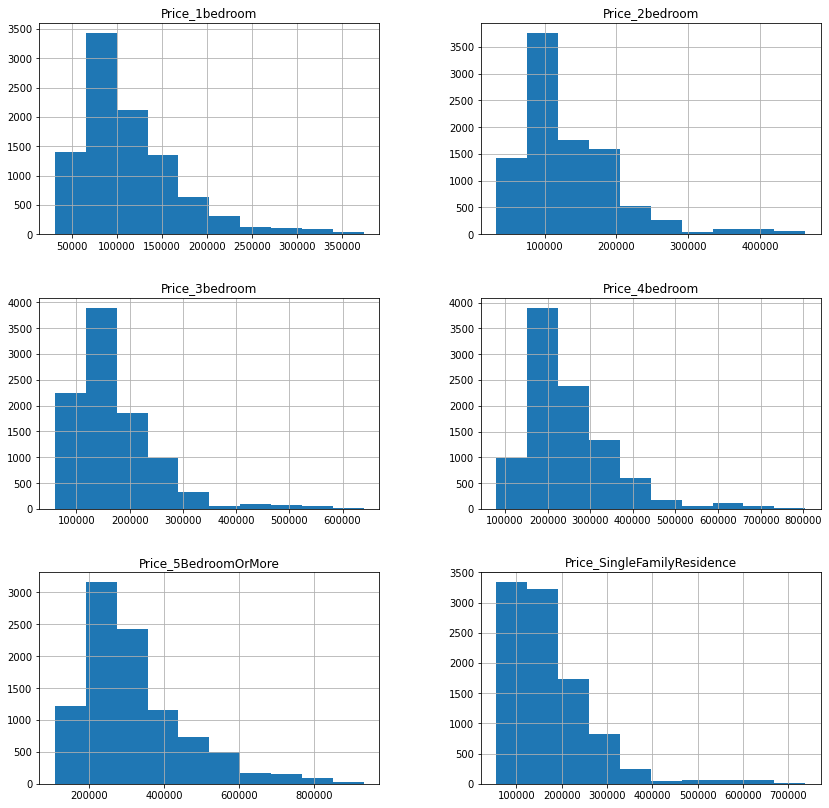

In [30]:
#histogram for different type of houses
df_hist = df.drop(columns=['Date'],axis=1)
df_hist.hist(figsize=(14,14));

In [31]:
#creat a pivot table of states regarding the date and total price of all type of houses
df['houseprice']=df['Price_1bedroom']+df['Price_2bedroom']+df['Price_3bedroom']+df['Price_4bedroom']+df['Price_5BedroomOrMore']+df['Price_SingleFamilyResidence']
house_price_by_region= pd.pivot_table(data=df, index='Date', columns='RegionName',values='houseprice')

In [32]:
display(house_price_by_region)
display(type(house_price_by_region))
display(house_price_by_region.dtypes)
display(house_price_by_region.index)

RegionName,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,Georgia,...,Ohio,Oklahoma,Oregon,Pennsylvania,RhodeIsland,SouthDakota,Tennessee,Virginia,Washington,Wisconsin
Date,,,,,,,,,,,,,,,,,,,,,
1996-04-30,620400.0,NaN,668100.0,569900.0,991400.0,826900.0,927700.0,723100.0,625500.0,682500.0,...,589100.0,418400.0,773600.0,604800.0,758500.0,NaN,593200.0,766000.0,837300.0,847200.0
1996-05-31,614900.0,NaN,668100.0,570700.0,988900.0,828800.0,926000.0,724200.0,626400.0,683200.0,...,590100.0,418000.0,776500.0,603900.0,755900.0,524300.0,595100.0,766400.0,837200.0,846600.0
1996-06-30,613100.0,NaN,669200.0,572600.0,984400.0,829600.0,926300.0,725800.0,625600.0,683400.0,...,590500.0,416900.0,779400.0,603300.0,753000.0,522200.0,597400.0,765600.0,836900.0,845600.0
1996-07-31,612600.0,NaN,670000.0,572900.0,980700.0,830400.0,927200.0,726400.0,624300.0,683300.0,...,591700.0,416300.0,782400.0,602300.0,749500.0,520000.0,599400.0,764500.0,837100.0,844500.0
1996-08-31,611800.0,NaN,670900.0,573100.0,977800.0,831300.0,926400.0,726800.0,623800.0,682800.0,...,592700.0,416200.0,785400.0,602000.0,746200.0,519600.0,601600.0,764100.0,837400.0,844000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-31,1007300.0,1704700.0,1446500.0,1050700.0,3170600.0,2119200.0,1725200.0,1436800.0,1482200.0,1197300.0,...,871900.0,837800.0,1995800.0,1162400.0,1778600.0,1091100.0,1203700.0,1723900.0,2240900.0,1053200.0
2017-09-30,1011800.0,1705200.0,1455300.0,1055200.0,3188700.0,2129000.0,1731800.0,1443700.0,1490900.0,1204300.0,...,876500.0,839800.0,2005500.0,1167900.0,1792400.0,1098300.0,1211500.0,1728900.0,2259300.0,1058900.0
2017-10-31,1013700.0,1707600.0,1465100.0,1059300.0,3209600.0,2139900.0,1736500.0,1455900.0,1499300.0,1209200.0,...,880900.0,841700.0,2012300.0,1173500.0,1807000.0,1103900.0,1218800.0,1732100.0,2278900.0,1063400.0


pandas.core.frame.DataFrame

RegionName
Alabama          float64
Alaska           float64
Arizona          float64
Arkansas         float64
California       float64
Colorado         float64
Connecticut      float64
Delaware         float64
Florida          float64
Georgia          float64
Hawaii           float64
Idaho            float64
Illinois         float64
Indiana          float64
Iowa             float64
Kentucky         float64
Maine            float64
Maryland         float64
Massachusetts    float64
Michigan         float64
Minnesota        float64
Missouri         float64
Montana          float64
Nebraska         float64
NewHampshire     float64
NewJersey        float64
NorthCarolina    float64
Ohio             float64
Oklahoma         float64
Oregon           float64
Pennsylvania     float64
RhodeIsland      float64
SouthDakota      float64
Tennessee        float64
Virginia         float64
Washington       float64
Wisconsin        float64
dtype: object

DatetimeIndex(['1996-04-30', '1996-05-31', '1996-06-30', '1996-07-31',
               '1996-08-31', '1996-09-30', '1996-10-31', '1996-11-30',
               '1996-12-31', '1997-01-31',
               ...
               '2017-03-31', '2017-04-30', '2017-05-31', '2017-06-30',
               '2017-07-31', '2017-08-31', '2017-09-30', '2017-10-31',
               '2017-11-30', '2017-12-31'],
              dtype='datetime64[ns]', name='Date', length=261, freq=None)

In [33]:
#looking for null value in the table,we drop some states that had lots of null values before ,we found before there is missing values by date
house_price_by_region.isnull().sum()

RegionName
Alabama           0
Alaska           17
Arizona           0
Arkansas          0
California        0
Colorado          0
Connecticut       0
Delaware          0
Florida           0
Georgia           0
Hawaii            0
Idaho             0
Illinois          0
Indiana           0
Iowa              0
Kentucky          0
Maine             0
Maryland          0
Massachusetts     0
Michigan          0
Minnesota         0
Missouri          0
Montana          21
Nebraska          0
NewHampshire      0
NewJersey         0
NorthCarolina     0
Ohio              0
Oklahoma          0
Oregon            0
Pennsylvania      0
RhodeIsland       0
SouthDakota       1
Tennessee         0
Virginia          0
Washington        0
Wisconsin         0
dtype: int64

In [34]:
#filling null values with the value of their previous month
house_price_by_region = house_price_by_region.fillna(method='bfill')


In [35]:
# Converting the index as date with monthly frequency
house_price_by_region.index = pd.to_datetime(house_price_by_region.index)
house_price_by_region= house_price_by_region.asfreq('M')
display(house_price_by_region.index)

DatetimeIndex(['1996-04-30', '1996-05-31', '1996-06-30', '1996-07-31',
               '1996-08-31', '1996-09-30', '1996-10-31', '1996-11-30',
               '1996-12-31', '1997-01-31',
               ...
               '2017-03-31', '2017-04-30', '2017-05-31', '2017-06-30',
               '2017-07-31', '2017-08-31', '2017-09-30', '2017-10-31',
               '2017-11-30', '2017-12-31'],
              dtype='datetime64[ns]', name='Date', length=261, freq='M')

#Data exploration


* How is the trend of the price of houses in the united states during the years:

* In what States the house price is higher
* compare total price of houses in different states
* How is the price in different months
* compare of price between different type of houses and how is the trend

**How is the trend of the price of houses in the united states during the years:**

In [36]:
#calculate total price in all states for every year(million dollar)
price_total = house_price_by_region.sum(axis=1)
price_total_by_year = price_total.resample('Y').sum()
price_total_by_year.index = price_total_by_year.index.year
price_total_by_year = price_total_by_year/1000000
display(price_total_by_year)

Date
1996    243.5418
1997    332.1849
1998    342.9098
1999    358.6687
2000    384.9062
2001    415.6583
2002    446.9236
2003    486.8667
2004    536.5568
2005    602.1028
2006    644.8727
2007    644.2798
2008    610.9264
2009    572.1096
2010    547.3534
2011    523.7189
2012    520.4686
2013    546.0905
2014    571.6898
2015    596.3480
2016    626.9211
2017    662.4067
dtype: float64

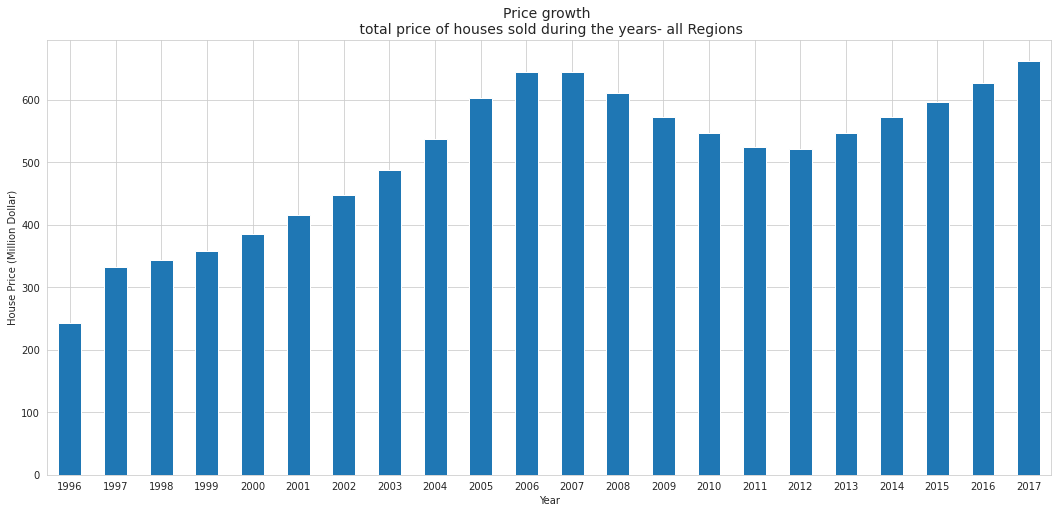

In [37]:
plt.figure(figsize=(18,8))
sns.set_style('whitegrid')
price_total_by_year.plot(kind='bar', rot=0, ylabel='House Price (Million Dollar)', xlabel='Year')
plt.title('Price growth \n total price of houses sold during the years- all Regions', fontsize=14)
plt.show()

**In what States the house price is higher**

In [38]:
#finding the top 10 most expensive states
price_total_by_Region = house_price_by_region.sum(axis=0)
price_total_by_regions = pd.Series(price_total_by_Region , name='RegionName')
price_total_by_regions_top10 = price_total_by_Region.sort_values(ascending=False).head(10)
display(price_total_by_regions_top10)

RegionName
Hawaii           671738100.0
California       567633000.0
Massachusetts    493029300.0
NewJersey        431455000.0
Connecticut      418604300.0
Washington       385042700.0
Alaska           384497000.0
Maryland         382427500.0
RhodeIsland      372439900.0
Virginia         363337400.0
dtype: float64

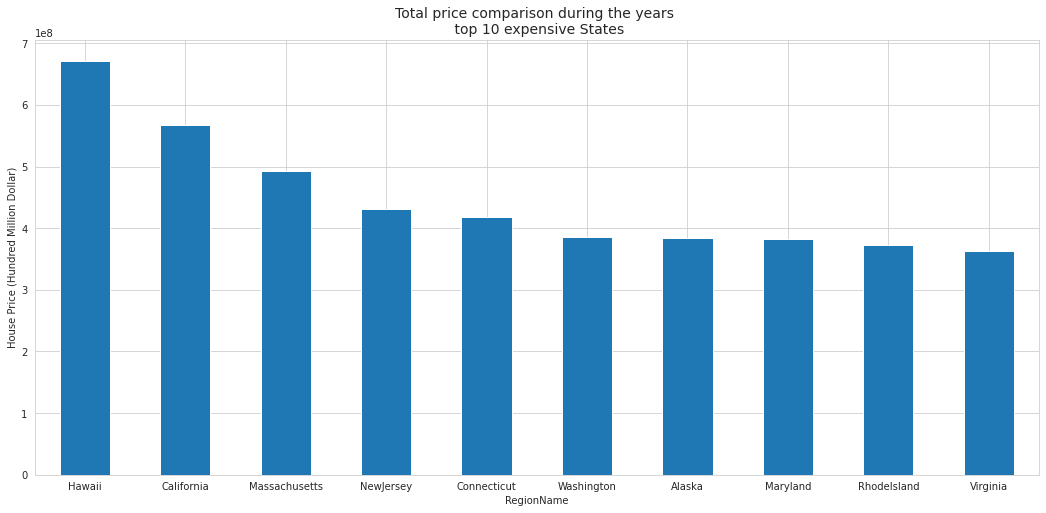

In [39]:
plt.figure(figsize=(18,8))
sns.set_style('whitegrid')
price_total_by_regions_top10.plot(kind='bar', rot=0, ylabel='House Price (Hundred Million Dollar)', xlabel='RegionName')
plt.title('Total price comparison during the years \n top 10 expensive States', fontsize=14)
plt.show()

**compare total price of houses in different states**

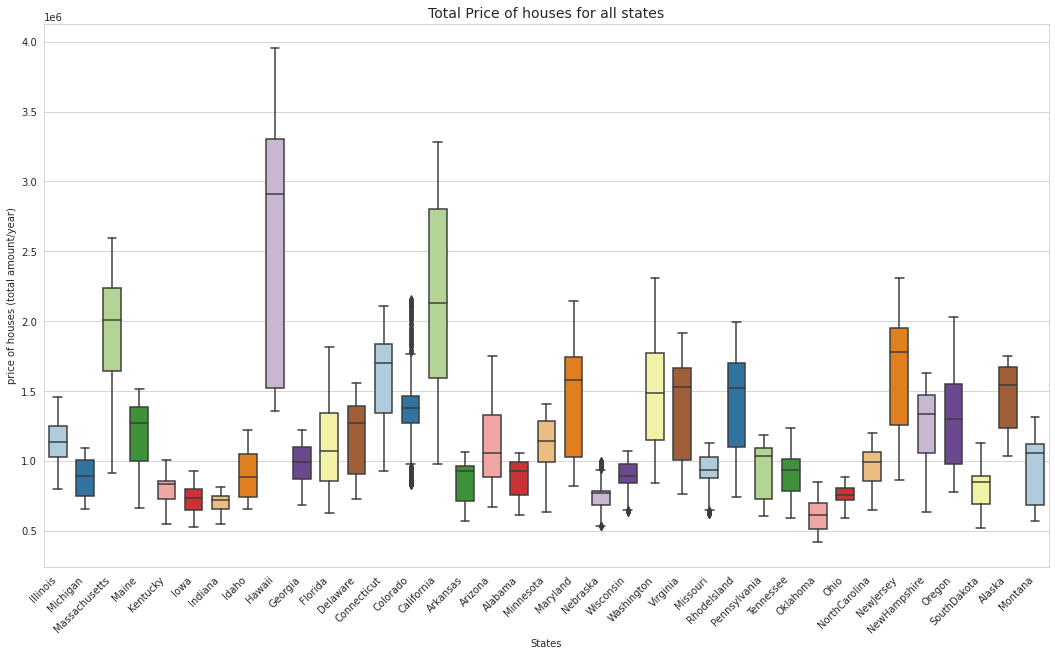

In [40]:
#check the total price of houses for all states
fig = plt.figure(figsize=(18,10))
ax  = fig.add_subplot()
sns.set_style('whitegrid')
sns.boxplot(x="RegionName", y="houseprice", data=df, palette='Paired', width=0.65)
plt.title('Total Price of houses for all states', fontsize=14)
plt.xlabel('States')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.ylabel('price of houses (total amount/year)')
plt.show()

**How is the price in different months**

In [41]:
#extract months and years of the date
price_groupby = df[['Date','RegionName','houseprice']].groupby(['Date','RegionName']).sum()
price_groupby['year'] = (price_groupby.index).to_series().map(lambda x : x[0].year)
price_groupby['month'] = (price_groupby.index).to_series().map(lambda x : x[0].month)
display(price_groupby)

houseprice  year  month
Date       RegionName                          
1996-04-30 Alabama        620400.0  1996      4
           Arizona        668100.0  1996      4
           Arkansas       569900.0  1996      4
           California     991400.0  1996      4
           Colorado       826900.0  1996      4
...                            ...   ...    ...
2017-12-31 SouthDakota   1123200.0  2017     12
           Tennessee     1232600.0  2017     12
           Virginia      1729000.0  2017     12
           Washington    2311900.0  2017     12
           Wisconsin     1069900.0  2017     12

[9618 rows x 3 columns]

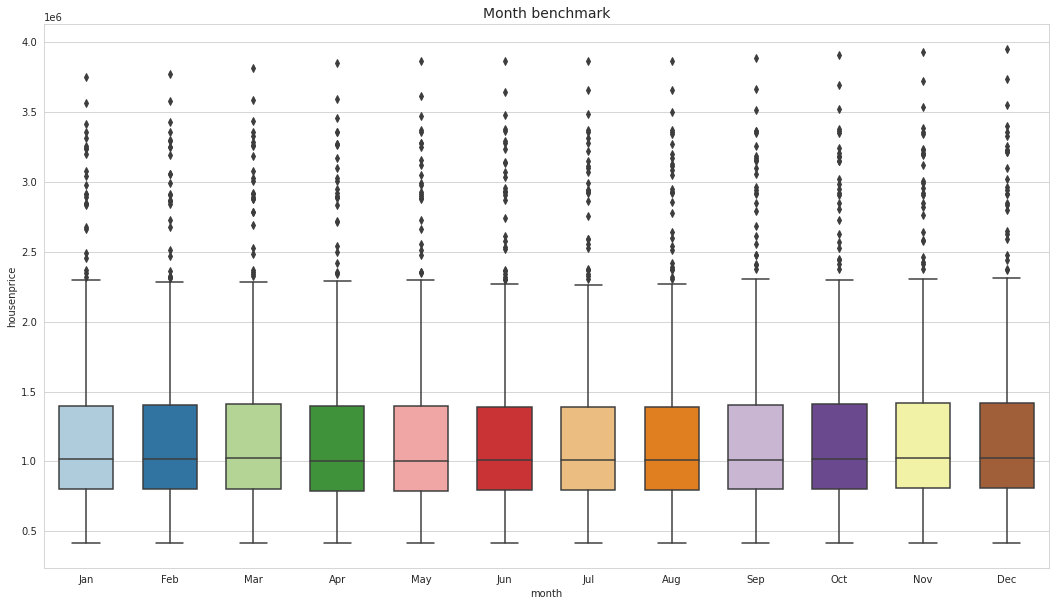

In [42]:
fig = plt.figure(figsize=(18,10))
ax  = fig.add_subplot()
sns.set_style('whitegrid')
sns.boxplot(data=price_groupby, x='month', y='houseprice', palette='Paired', width=0.65)
plt.title('Month benchmark', fontsize=14)
plt.ylabel('housenprice')
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.show()

**compare of price between different type of houses and how is the trend**

In [43]:
#compare of price between different type of houses
d=df.groupby('Date').sum()[['Price_1bedroom','Price_2bedroom','Price_3bedroom','Price_4bedroom' ,'Price_5BedroomOrMore' ,'Price_SingleFamilyResidence']]
d.index = pd.to_datetime(d.index)
d= d.asfreq('M')
pr = d.resample('Y').sum()
pr.index = pr.index.year
pr.reset_index(level=0, inplace=True)

In [44]:
fig = px.line(pr,x='Date',y=['Price_1bedroom','Price_2bedroom','Price_3bedroom','Price_4bedroom' ,'Price_5BedroomOrMore' ,'Price_SingleFamilyResidence'])
fig.update_layout(title='<b>price growth of different type of Houses in USA<b> ',plot_bgcolor = 'whitesmoke')
fig.show()

#Discriptive Statistics-Time series Analysis for 3 bedroom houses

In this step, I want to have an analysis on the one type of houses price (3-bedroom)

In [45]:
#make a pivot table of "price-3 bedroom" column 
house3b_price_states= pd.pivot_table(data=df, index='Date', columns='RegionName',values='Price_3bedroom')

In [46]:
display(house3b_price_states)
display(type(house3b_price_states))
display(house3b_price_states.dtypes)
display(house3b_price_states.index)

RegionName,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,Georgia,...,Ohio,Oklahoma,Oregon,Pennsylvania,RhodeIsland,SouthDakota,Tennessee,Virginia,Washington,Wisconsin
Date,,,,,,,,,,,,,,,,,,,,,
1996-04-30,78200.0,NaN,96100.0,76800.0,150900.0,129000.0,130400.0,103500.0,89100.0,88000.0,...,87900.0,59400.0,124500.0,85400.0,115000.0,NaN,80900.0,100300.0,135800.0,144500.0
1996-05-31,78200.0,NaN,96800.0,77300.0,150900.0,129400.0,130900.0,103800.0,89500.0,88200.0,...,88100.0,59700.0,125200.0,85700.0,115600.0,83100.0,81200.0,100700.0,136000.0,144500.0
1996-06-30,78400.0,NaN,97400.0,77800.0,150600.0,129600.0,131300.0,103900.0,89600.0,88400.0,...,88300.0,60000.0,125900.0,85700.0,115600.0,82500.0,81600.0,100900.0,135900.0,144500.0
1996-07-31,78600.0,NaN,97600.0,77800.0,150300.0,129600.0,131700.0,104100.0,89600.0,88700.0,...,88600.0,60100.0,126500.0,85700.0,115600.0,82200.0,82100.0,101100.0,135900.0,144500.0
1996-08-31,78800.0,NaN,97800.0,77900.0,150100.0,129800.0,131700.0,104800.0,89600.0,88700.0,...,88900.0,60200.0,127200.0,85900.0,115600.0,82400.0,82500.0,101500.0,136100.0,144500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-31,127700.0,279500.0,219100.0,140700.0,482600.0,334200.0,237700.0,214000.0,215200.0,146700.0,...,126300.0,119800.0,305400.0,160900.0,257700.0,175000.0,159400.0,219700.0,337800.0,166600.0
2017-09-30,128400.0,279500.0,220700.0,141200.0,485500.0,335900.0,238600.0,215200.0,216800.0,147800.0,...,126900.0,120300.0,307000.0,162000.0,259800.0,176200.0,160700.0,220400.0,340500.0,167700.0
2017-10-31,128800.0,280000.0,222300.0,141600.0,488700.0,337900.0,239400.0,216800.0,218400.0,148500.0,...,127600.0,120800.0,308100.0,162700.0,261800.0,176900.0,161900.0,221100.0,343300.0,168500.0


pandas.core.frame.DataFrame

RegionName
Alabama          float64
Alaska           float64
Arizona          float64
Arkansas         float64
California       float64
Colorado         float64
Connecticut      float64
Delaware         float64
Florida          float64
Georgia          float64
Hawaii           float64
Idaho            float64
Illinois         float64
Indiana          float64
Iowa             float64
Kentucky         float64
Maine            float64
Maryland         float64
Massachusetts    float64
Michigan         float64
Minnesota        float64
Missouri         float64
Montana          float64
Nebraska         float64
NewHampshire     float64
NewJersey        float64
NorthCarolina    float64
Ohio             float64
Oklahoma         float64
Oregon           float64
Pennsylvania     float64
RhodeIsland      float64
SouthDakota      float64
Tennessee        float64
Virginia         float64
Washington       float64
Wisconsin        float64
dtype: object

DatetimeIndex(['1996-04-30', '1996-05-31', '1996-06-30', '1996-07-31',
               '1996-08-31', '1996-09-30', '1996-10-31', '1996-11-30',
               '1996-12-31', '1997-01-31',
               ...
               '2017-03-31', '2017-04-30', '2017-05-31', '2017-06-30',
               '2017-07-31', '2017-08-31', '2017-09-30', '2017-10-31',
               '2017-11-30', '2017-12-31'],
              dtype='datetime64[ns]', name='Date', length=261, freq=None)

In [47]:
#check for null value in the pivot table
house3b_price_states.isnull().sum()

RegionName
Alabama           0
Alaska           17
Arizona           0
Arkansas          0
California        0
Colorado          0
Connecticut       0
Delaware          0
Florida           0
Georgia           0
Hawaii            0
Idaho             0
Illinois          0
Indiana           0
Iowa              0
Kentucky          0
Maine             0
Maryland          0
Massachusetts     0
Michigan          0
Minnesota         0
Missouri          0
Montana          21
Nebraska          0
NewHampshire      0
NewJersey         0
NorthCarolina     0
Ohio              0
Oklahoma          0
Oregon            0
Pennsylvania      0
RhodeIsland       0
SouthDakota       1
Tennessee         0
Virginia          0
Washington        0
Wisconsin         0
dtype: int64

In [48]:
#filling null values with the value of their previous month
house3b_price_states = house3b_price_states.fillna(method='bfill')

In [49]:
# Converting the index as date with monthly frequency
house3b_price_states.index = pd.to_datetime(house3b_price_states.index)
house3b_price_states= house3b_price_states.asfreq('M')
display(house3b_price_states.index)

DatetimeIndex(['1996-04-30', '1996-05-31', '1996-06-30', '1996-07-31',
               '1996-08-31', '1996-09-30', '1996-10-31', '1996-11-30',
               '1996-12-31', '1997-01-31',
               ...
               '2017-03-31', '2017-04-30', '2017-05-31', '2017-06-30',
               '2017-07-31', '2017-08-31', '2017-09-30', '2017-10-31',
               '2017-11-30', '2017-12-31'],
              dtype='datetime64[ns]', name='Date', length=261, freq='M')

In [50]:
# Discriptive Statistics of 3- bedroom house price
descriptive_stat = house3b_price_states.describe().T

Q1 = house3b_price_states.quantile(0.25)
Q3 = house3b_price_states.quantile(0.75)
IQR = Q3 - Q1

outlier_lower_count = (house3b_price_states < (Q1 - 1.5 * IQR)).sum()
outlier_upper_count = (house3b_price_states > (Q3 + 1.5 * IQR)).sum()
outlier_total_count = outlier_lower_count + outlier_upper_count

descriptive_stat['range']=descriptive_stat['max']-descriptive_stat['min']
descriptive_stat['IQR']=descriptive_stat['75%']-descriptive_stat['25%']
descriptive_stat['outlier_lower_count'] = outlier_lower_count
descriptive_stat['outlier_upper_count'] = outlier_upper_count
descriptive_stat['outlier_total_count'] = outlier_total_count

display(round(descriptive_stat,2))

,count,mean,std,min,25%,50%,75%,max,range,IQR,outlier_lower_count,outlier_upper_count,outlier_total_count
RegionName,,,,,,,,,,,,,
Alabama,261.0,111212.64,16519.48,78200.0,96900.0,116800.0,123900.0,135200.0,57000.0,27000.0,0,0,0
Alaska,261.0,239643.30,37275.64,168700.0,206500.0,251100.0,269900.0,284100.0,115400.0,63400.0,0,0,0
Arizona,261.0,161851.34,45525.07,96100.0,125100.0,150800.0,194300.0,257600.0,161500.0,69200.0,0,0,0
Arkansas,261.0,113031.80,19589.74,76800.0,93400.0,122500.0,127700.0,142700.0,65900.0,34300.0,0,0,0
California,261.0,329293.10,112412.10,149900.0,235300.0,316100.0,426600.0,511600.0,361700.0,191300.0,0,0,0
Colorado,261.0,211851.72,47552.83,129000.0,195700.0,210600.0,224100.0,341600.0,212600.0,28400.0,37,32,69
Connecticut,261.0,218371.26,47210.35,130400.0,177800.0,231400.0,249000.0,286300.0,155900.0,71200.0,0,0,0
Delaware,261.0,171124.14,39991.75,103500.0,129200.0,182600.0,204100.0,228400.0,124900.0,74900.0,0,0,0
Florida,261.0,155846.74,47287.32,89100.0,120600.0,147800.0,188300.0,259300.0,170200.0,67700.0,0,0,0


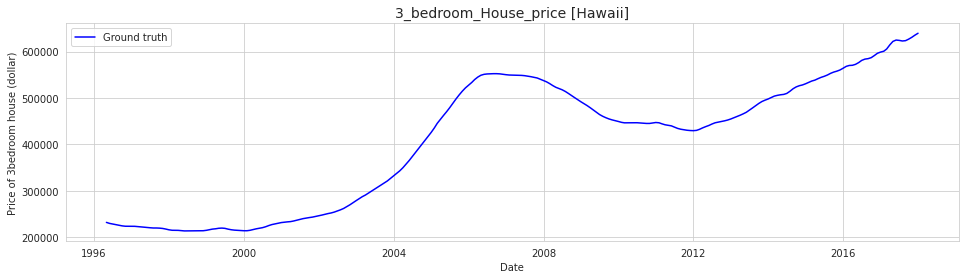

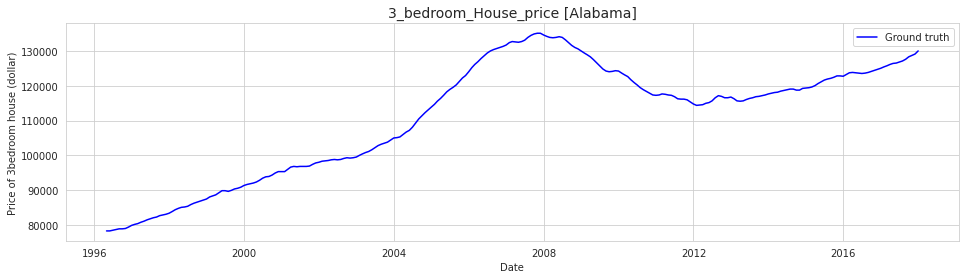

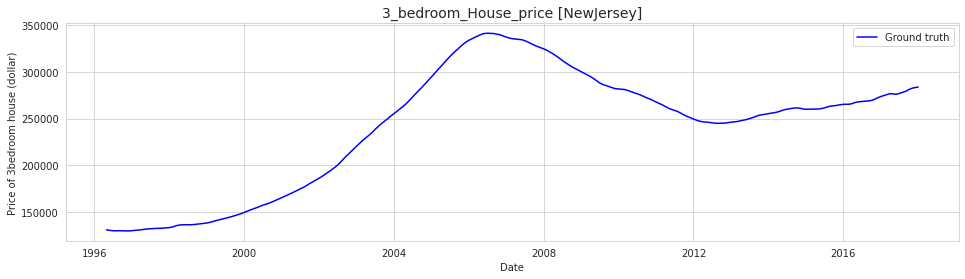

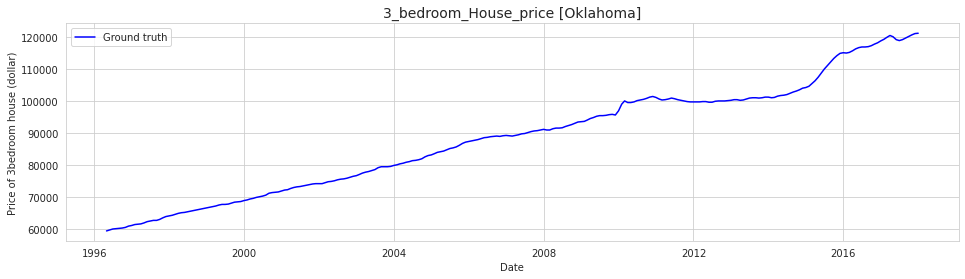

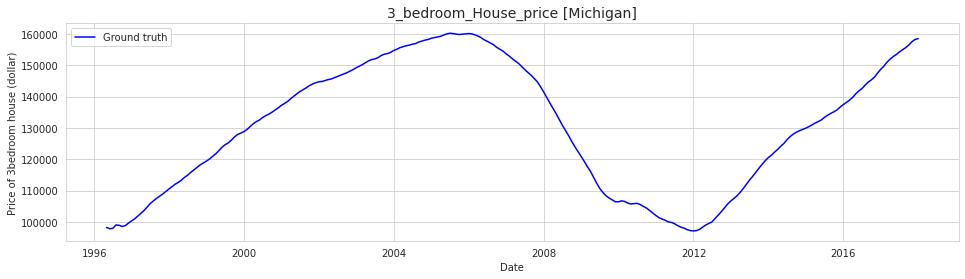

In [51]:
#visualisation of price trend for 3 states
house3b_price_han = ['Hawaii','Alabama','NewJersey','Oklahoma','Michigan']
for state in house3b_price_han:
    #time series
    ts = pd.DataFrame(house3b_price_states[state])
    #plot
    plt.figure(figsize=(16,4))
    plt.plot(ts, color='blue', label='Ground truth')
    plt.title('3_bedroom_House_price [{}]'.format(state), fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('Price of 3bedroom house (dollar)')
    plt.legend()
    plt.show()

#Analysis of State,Hawaii for 3-bed room house price

In [52]:
Hawaii_ts = pd.DataFrame(house3b_price_states['Hawaii'])

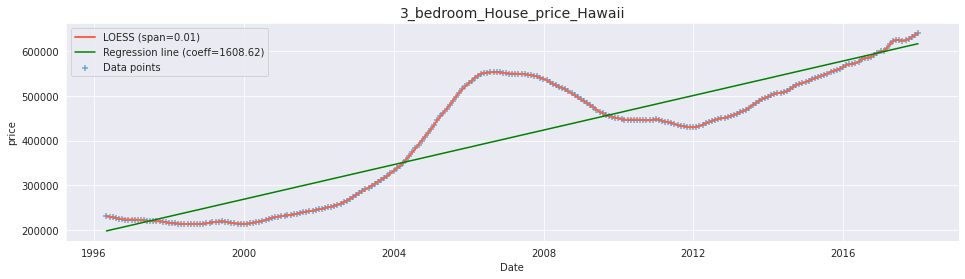

In [53]:
plotTS(Hawaii_ts, column='Hawaii',figsize=(16,4), title='3_bedroom_House_price_Hawaii', xlabel='Date', ylabel='price')

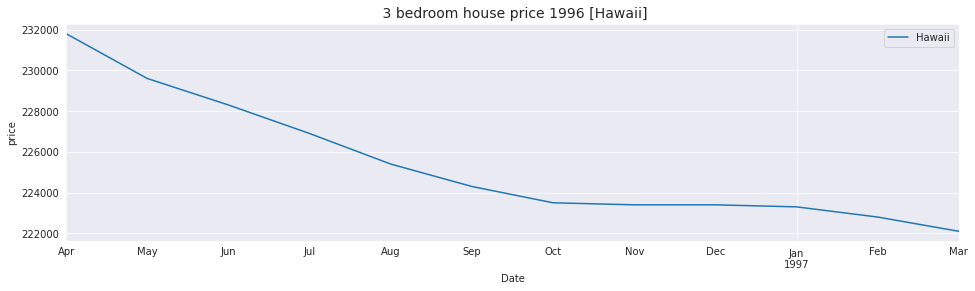

In [54]:
#see the value trend for the first 12 months
fig = Hawaii_ts[0:12].plot(figsize=(16,4), title=' 3 bedroom house price 1996 [Hawaii]')
fig.axes.title.set_size(14)
plt.xlabel('Date')
plt.ylabel('price')
plt.show()

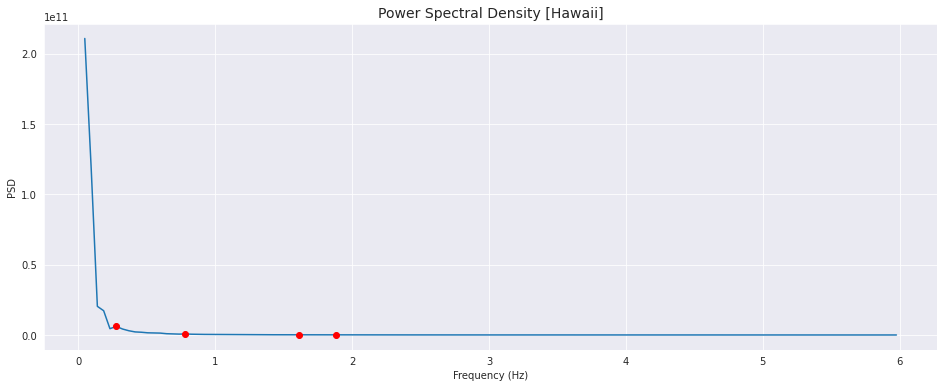

,Freq,Power,Period (year)
0,0.275862,6.150156e+09,3.625000
1,0.781609,7.519129e+08,1.279412
2,1.609195,1.742048e+08,0.621429
3,1.885057,1.438472e+08,0.530488


In [55]:
#check frequency by power spectral density
Fs = 12  #per year-consider 12 months
f_per, Pxx_per = signal.periodogram(Hawaii_ts['Hawaii'],Fs,window=None,return_onesided=True,scaling='density')
sns.set_style('darkgrid')
plt.figure(figsize=(16,6))
plt.title('Power Spectral Density [Hawaii]', fontsize=14)
plt.plot(f_per[1:],Pxx_per[1:])
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')

f_per = f_per[1:]
Pxx_per = Pxx_per[1:]
peaks = signal.find_peaks(Pxx_per[ f_per >= 0], prominence=8000000)[0]
peaks_freq = f_per[peaks]
peaks_power = Pxx_per[peaks]
plt.plot(peaks_freq, peaks_power, 'ro')
plt.show()

data = {'Freq':peaks_freq, 'Power':peaks_power}
df_PSD = pd.DataFrame(data)
df_PSD['Period (year)'] = 1/df_PSD['Freq']
display(df_PSD)

#Stationarity

In [56]:
checkStationarity(Hawaii_ts['Hawaii'], kpss_type='c')

*** ADF Test ***
ADF Statistic:  -1.1425767322763127
p-value:  0.6977977432903587
Interpretation: The time series is non-stationary (Ho)

*** KPSS Test ***
KPSS Statistic: 1.9790740118996497
p-value:  0.01
Interpretation: The time series is not stationary (Ha)


In [57]:
checkStationarity(Hawaii_ts['Hawaii'], kpss_type='ct')

*** ADF Test ***
ADF Statistic:  -1.1425767322763127
p-value:  0.6977977432903587
Interpretation: The time series is non-stationary (Ho)

*** KPSS Test ***
KPSS Statistic: 0.2716139144571212
p-value:  0.01
Interpretation: The time series is not trend stationary (Ha)


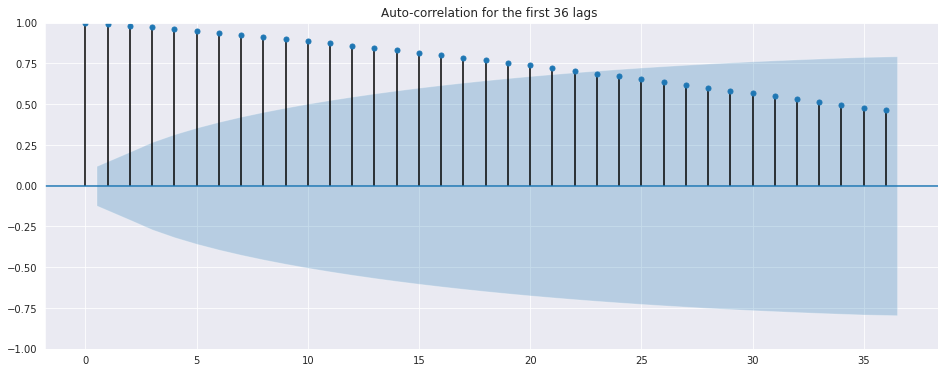

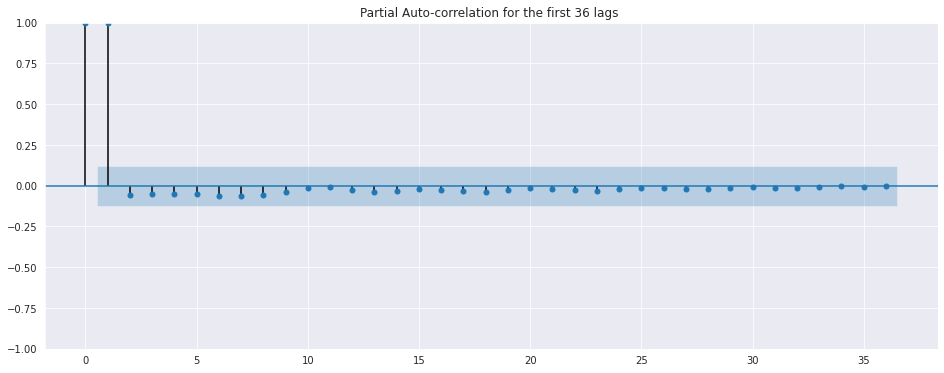

*** Ljung-Box Test [36 lags] ***
Q:  5888.183233428478
p-value:  0.0
Interpretation: The residuals are not independently distributed, they exhibit serial correlation (Ha)

*** Breusch-Godfrey Test [36 lags] ***
Lagrange multiplier statistic:  260.5762732125327
p-value:  7.569242021635196e-36
Interpretation: There exists autocorrelation at some order less than or equal to p (Ha)


In [58]:
autocorrelationPlot(Hawaii_ts['Hawaii'], lags=36)
checkAutorcorrelation(Hawaii_ts['Hawaii'].values, lags=36)

In [ ]:
# Data are clearly non-stationary. As first step we perfom a seasonal difference
#data_diff_seas = Hawaii_ts['Hawaii'].diff(12)
#data_diff_seas.dropna(inplace=True)
#plt.plot(data_diff_seas)
#plt.xlabel('Time')
#plt.ylabel('Seasonally differenced');

In [ ]:
#checkStationarity(data_diff_seas, kpss_type='c')

In [ ]:
#checkStationarity(data_diff_seas, kpss_type='ct')

In [ ]:
#autocorrelationPlot(data_diff_seas, lags=36)
#checkAutorcorrelation(data_diff_seas.values, lags=36)

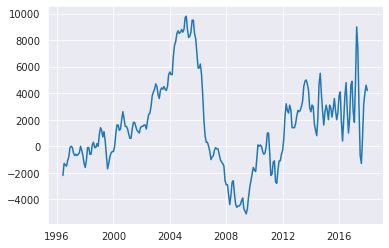

In [134]:
data_diff_seas_first = Hawaii_ts['Hawaii'].diff()
data_diff_seas_first.dropna(inplace=True)
plt.plot(data_diff_seas_first)

In [135]:
checkStationarity(data_diff_seas_first, kpss_type='c')

*** ADF Test ***
ADF Statistic:  -2.0786454720576915
p-value:  0.25318759872406016
Interpretation: The time series is non-stationary (Ho)

*** KPSS Test ***
KPSS Statistic: 0.18939756427693702
p-value:  0.1
Interpretation: The time series is stationary (Ho)


In [136]:
checkStationarity(data_diff_seas_first, kpss_type='ct')

*** ADF Test ***
ADF Statistic:  -2.0786454720576915
p-value:  0.25318759872406016
Interpretation: The time series is non-stationary (Ho)

*** KPSS Test ***
KPSS Statistic: 0.18708906263213915
p-value:  0.020841601512947817
Interpretation: The time series is not trend stationary (Ha)


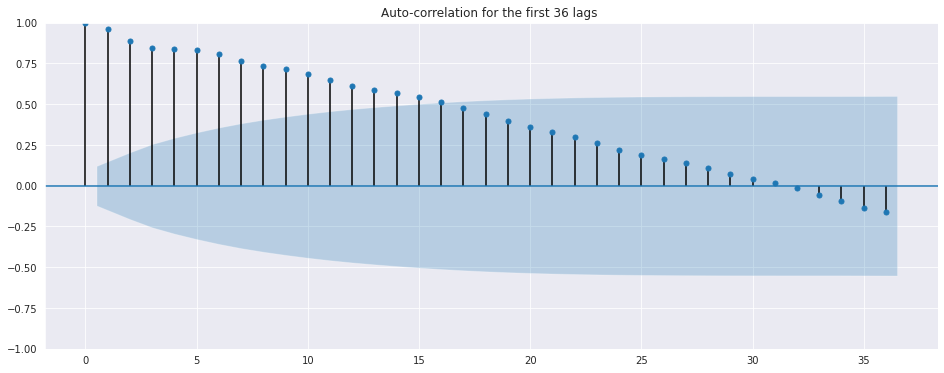

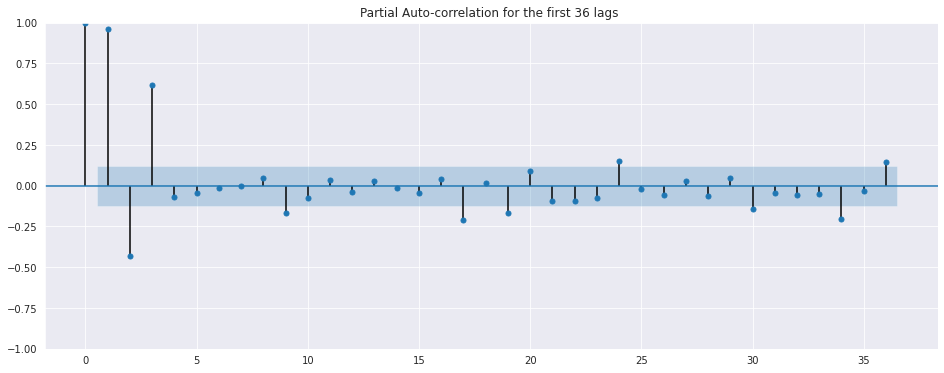

*** Ljung-Box Test [36 lags] ***
Q:  2652.543610588801
p-value:  0.0
Interpretation: The residuals are not independently distributed, they exhibit serial correlation (Ha)

*** Breusch-Godfrey Test [36 lags] ***
Lagrange multiplier statistic:  250.36547068222026
p-value:  6.364801308943987e-34
Interpretation: There exists autocorrelation at some order less than or equal to p (Ha)


In [137]:
autocorrelationPlot(data_diff_seas_first, lags=36)
checkAutorcorrelation(data_diff_seas_first.values, lags=36)

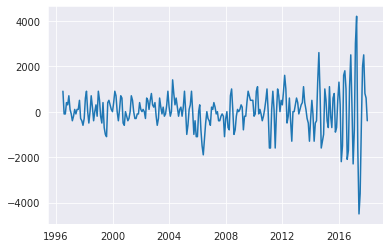

In [138]:
data_diff_seas_second = data_diff_seas_first.diff()
data_diff_seas_second.dropna(inplace=True)
plt.plot(data_diff_seas_second)

In [139]:
checkStationarity(data_diff_seas_second, kpss_type='c')

*** ADF Test ***
ADF Statistic:  -5.112055559211034
p-value:  1.3257237083122235e-05
Interpretation: The time series is stationary (Ha)

*** KPSS Test ***
KPSS Statistic: 0.089971185101403
p-value:  0.1
Interpretation: The time series is stationary (Ho)


In [140]:
checkStationarity(data_diff_seas_second, kpss_type='ct')

*** ADF Test ***
ADF Statistic:  -5.112055559211034
p-value:  1.3257237083122235e-05
Interpretation: The time series is stationary (Ha)

*** KPSS Test ***
KPSS Statistic: 0.08816536008659222
p-value:  0.1
Interpretation: The time series is trend stationary (Ho)


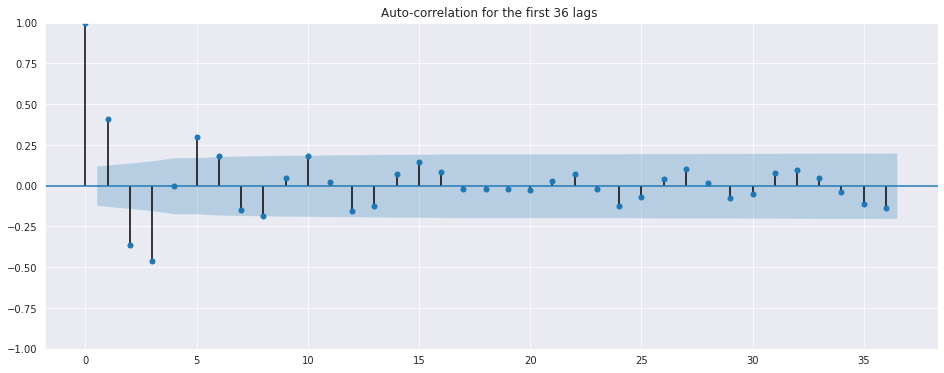

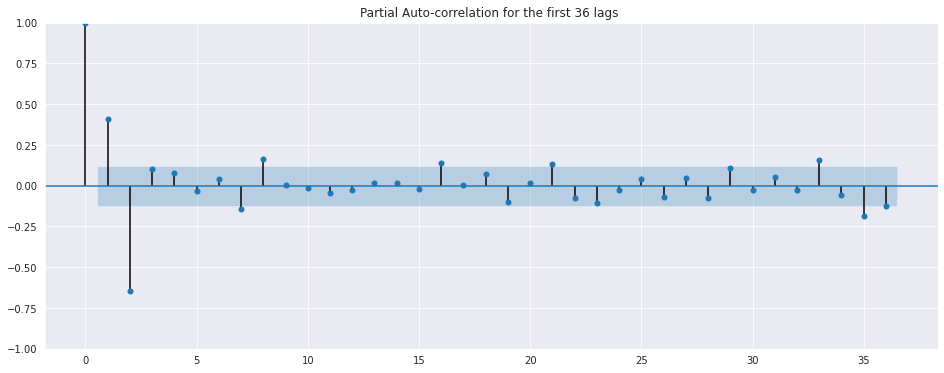

*** Ljung-Box Test [36 lags] ***
Q:  241.7316323758108
p-value:  2.641773492071585e-32
Interpretation: The residuals are not independently distributed, they exhibit serial correlation (Ha)

*** Breusch-Godfrey Test [36 lags] ***
Lagrange multiplier statistic:  167.4686457053272
p-value:  7.411308523534819e-19
Interpretation: There exists autocorrelation at some order less than or equal to p (Ha)


In [141]:
autocorrelationPlot(data_diff_seas_second, lags=36)
checkAutorcorrelation(data_diff_seas_second.values, lags=36)

#decomposition

so we do decomposition and analysis of residuals

In [71]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [72]:
#extracting components
sdecom = seasonal_decompose(Hawaii_ts['Hawaii'], model='additive', period=12, two_sided=True)

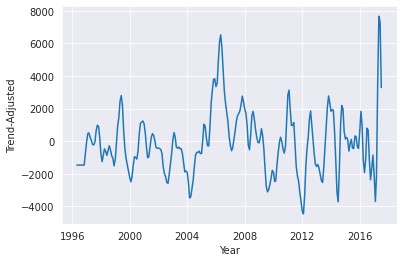

In [73]:
data_diff_seas_detrend = Hawaii_ts['Hawaii']-sdecom.trend
data_diff_seas_detrend.fillna(method='bfill',inplace=True)
data_diff_seas_detrend.dropna(inplace=True)
plt.plot(data_diff_seas_detrend)
plt.xlabel('Year')
plt.ylabel('Trend-Adjusted');

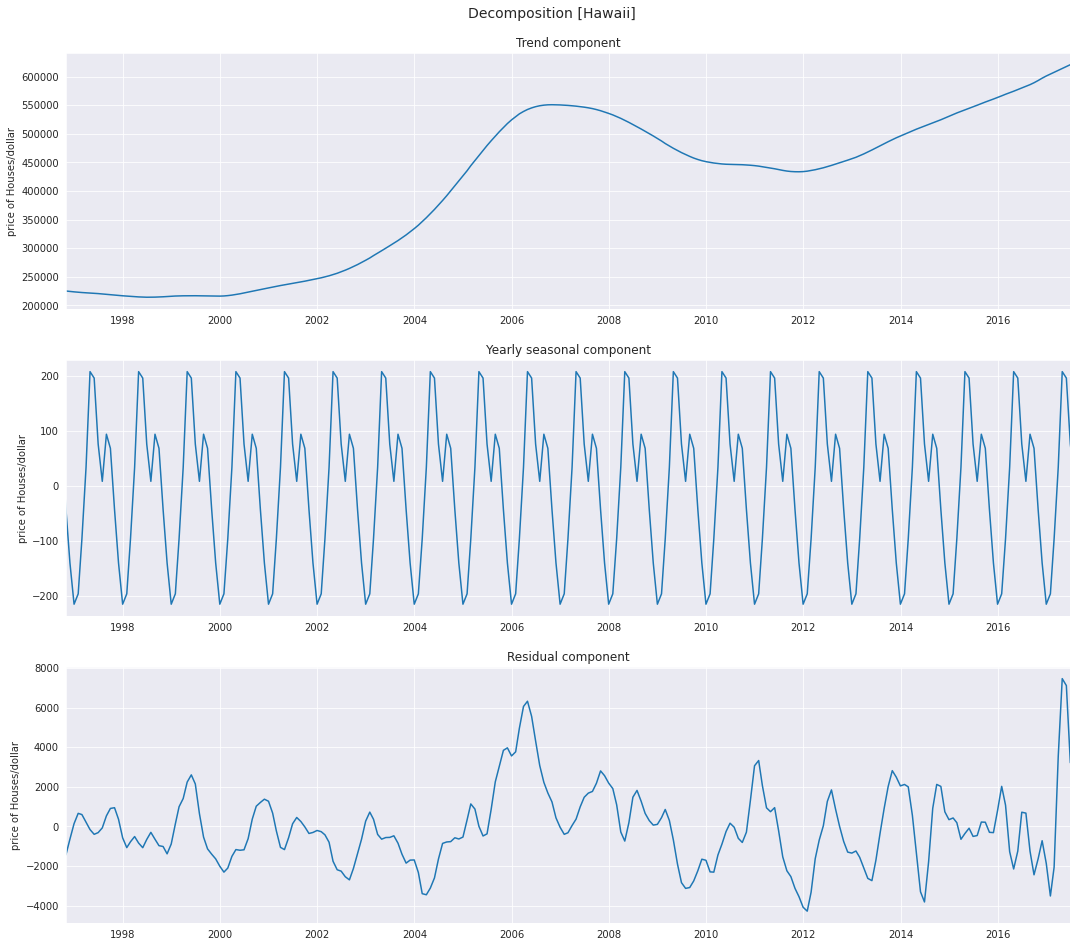

In [74]:
f, axes = plt.subplots(3,1,figsize=(18,16))
plt.suptitle('Decomposition [Hawaii]', y=0.92, fontsize=14)

#plotting trend component
axes[0].plot(sdecom.trend)
axes[0].set_title('Trend component', fontdict={'fontsize': 12})

#plotting yearly seasonal component
axes[1].plot(sdecom.seasonal)
axes[1].set_title('Yearly seasonal component', fontdict={'fontsize': 12})

#plotting residual of decomposition
axes[2].plot(sdecom .resid)
axes[2].set_title('Residual component', fontdict={'fontsize': 12})

for a in axes:
    a.set_ylabel('price of Houses/dollar')
    a.set_xlim(sdecom.trend.dropna().index[0], sdecom.trend.dropna().index[-1])

#showing chart
plt.show()

**decomposition-residual**

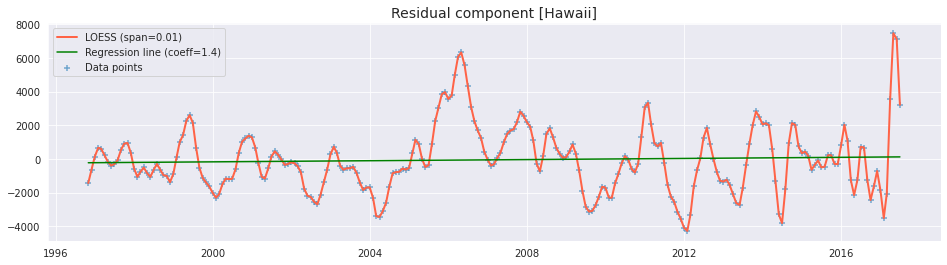

In [75]:
decomp_residuals = pd.DataFrame(sdecom.resid.dropna())
plotTS(decomp_residuals, column='resid', figsize=(16,4), title='Residual component [Hawaii]')

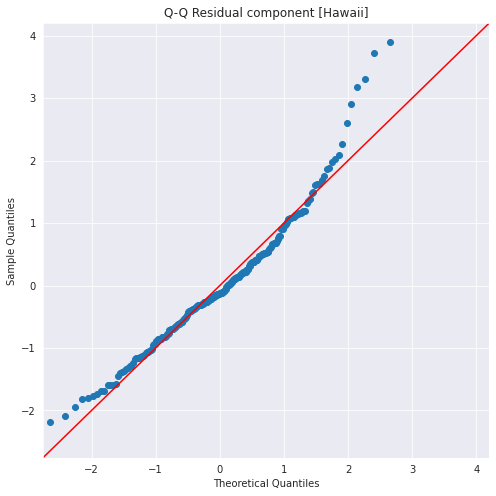

*** Shapiro-Wilk Test ***
W:  0.9613144993782043
p-value:  3.03938190882036e-06
Interpretation: the data was not drawn from a normal distribution (Ha)

*** Jarque-Bera Test ***
Jarque-Bera JB:  56.38712311887945
p-value:  5.697664562376303e-13
Interpretation: the data was not drawn from a normal distribution (Ha)

*** D’Agostino-Pearson Test ***
k2:  [35.71807064]
p-value:  [1.75355547e-08]
Interpretation: the data was not drawn from a normal distribution (Ha)

----------------------------------------------------------------------
Skewness:  [0.83061336]
Kurtosis :  [1.63561279]


In [76]:
qqPlot(decomp_residuals['resid'], title='Residual component [Hawaii]')
checkNormality(decomp_residuals)

In [77]:
checkStationarity(decomp_residuals, kpss_type='c')

*** ADF Test ***
ADF Statistic:  -3.243762032659012
p-value:  0.017587252885319097
Interpretation: The time series is stationary (Ha)

*** KPSS Test ***
KPSS Statistic: 0.09616212167152538
p-value:  0.1
Interpretation: The time series is stationary (Ho)


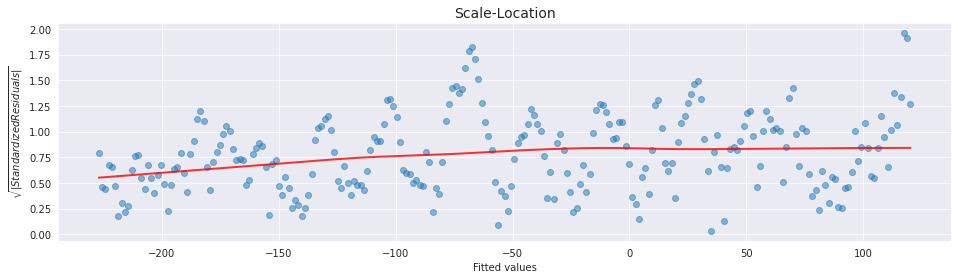

*** Koenker Test ***
Lagrange multiplier statistic:  10.377381778325029
p-value:  0.0012756847080416269
Interpretation: Heteroscedasticity is present, the residuals are not distributed with equal variance (Ha)


In [78]:
scalelocationPlot(decomp_residuals['resid'], figsize=(16,4))
checkHomoscedasticity(decomp_residuals, robust=True)

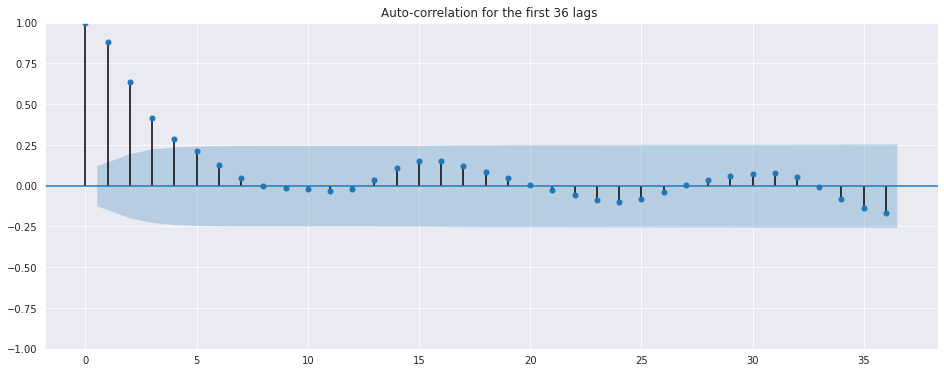

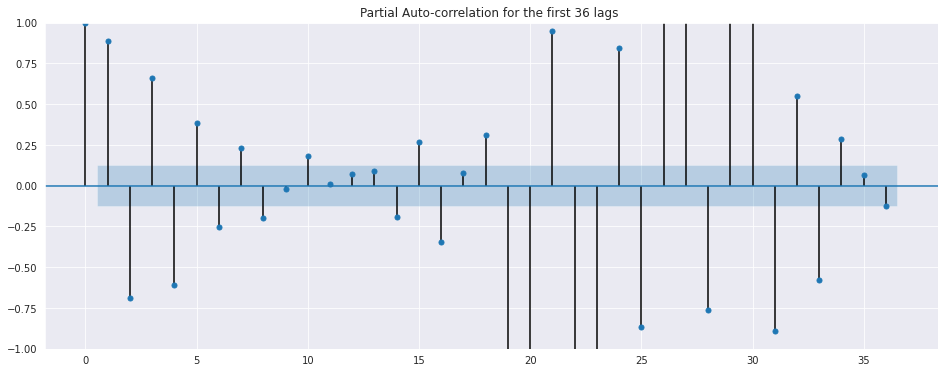

*** Ljung-Box Test [36 lags] ***
Q:  431.41757292585385
p-value:  3.0131091301137336e-69
Interpretation: The residuals are not independently distributed, they exhibit serial correlation (Ha)

*** Breusch-Godfrey Test [36 lags] ***
Lagrange multiplier statistic:  235.49780839896283
p-value:  3.841537038443669e-31
Interpretation: There exists autocorrelation at some order less than or equal to p (Ha)


In [79]:
autocorrelationPlot(decomp_residuals['resid'], lags=36)
checkAutorcorrelation(decomp_residuals, lags=36)

#**Models**

finding the appropriate model, I will try 3 different models

In [80]:
# Train and test 
data_train = Hawaii_ts[:-24]['Hawaii'] 
data_test = Hawaii_ts[-24:]['Hawaii']

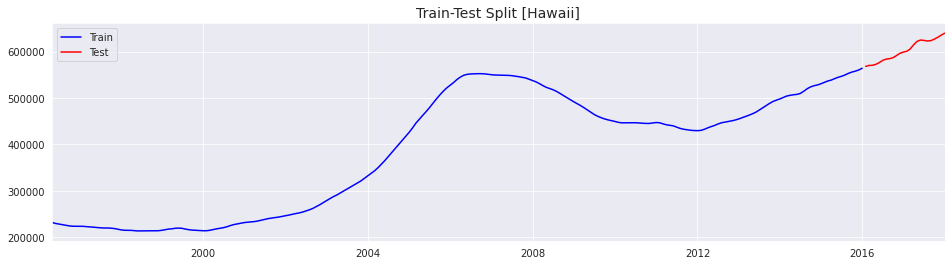

In [81]:
plt.figure(figsize=(16,4))
plt.plot(data_train, color='blue', label='Train')
plt.plot(data_test, color='red', label='Test')
plt.xlim(data_train.index[0],data_test.index[-1])
plt.title('Train-Test Split [Hawaii]', fontsize=14)
plt.legend()
plt.show()

# SARIMA

In [82]:
trans = FourierFeaturizer(12, 2)
y_prime, X = trans.fit_transform(Hawaii_ts['Hawaii'])
X.index = Hawaii_ts['Hawaii'].index
display(X)

Y_train = Hawaii_ts['Hawaii'][:'2015-12-31']
X_train = X['2015-12-31':]
Y_test = data_diff_seas_first['2016-01-01':]
X_test = X['2016-01-01':]

,FOURIER_S12-0,FOURIER_C12-0,FOURIER_S12-1,FOURIER_C12-1
Date,,,,
1996-04-30,0.500000,8.660254e-01,8.660254e-01,0.500000
1996-05-31,0.866025,5.000000e-01,8.660254e-01,-0.500000
1996-06-30,1.000000,-4.371139e-08,-8.742278e-08,-1.000000
1996-07-31,0.866025,-5.000001e-01,-8.660255e-01,-0.500000
1996-08-31,0.500000,-8.660254e-01,-8.660253e-01,0.500000
...,...,...,...,...
2017-08-31,0.499997,-8.660273e-01,-8.660217e-01,0.500006
2017-09-30,-0.000004,-1.000000e+00,7.518359e-06,1.000000
2017-10-31,-0.500003,-8.660235e-01,8.660292e-01,0.499993


Performing stepwise search to minimize aicc
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AICC=4498.089, Time=1.19 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AICC=4496.938, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AICC=4511.393, Time=3.29 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AICC=4492.739, Time=0.70 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AICC=4534.531, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AICC=4493.411, Time=0.30 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AICC=4494.808, Time=2.33 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AICC=4494.796, Time=0.77 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AICC=4492.813, Time=0.37 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AICC=inf, Time=5.71 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AICC=4496.022, Time=0.31 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AICC=4482.546, Time=3.15 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AICC=4461.640, Time=1.22 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AICC=4485.164, Time=2.36 sec
 ARIMA(1,

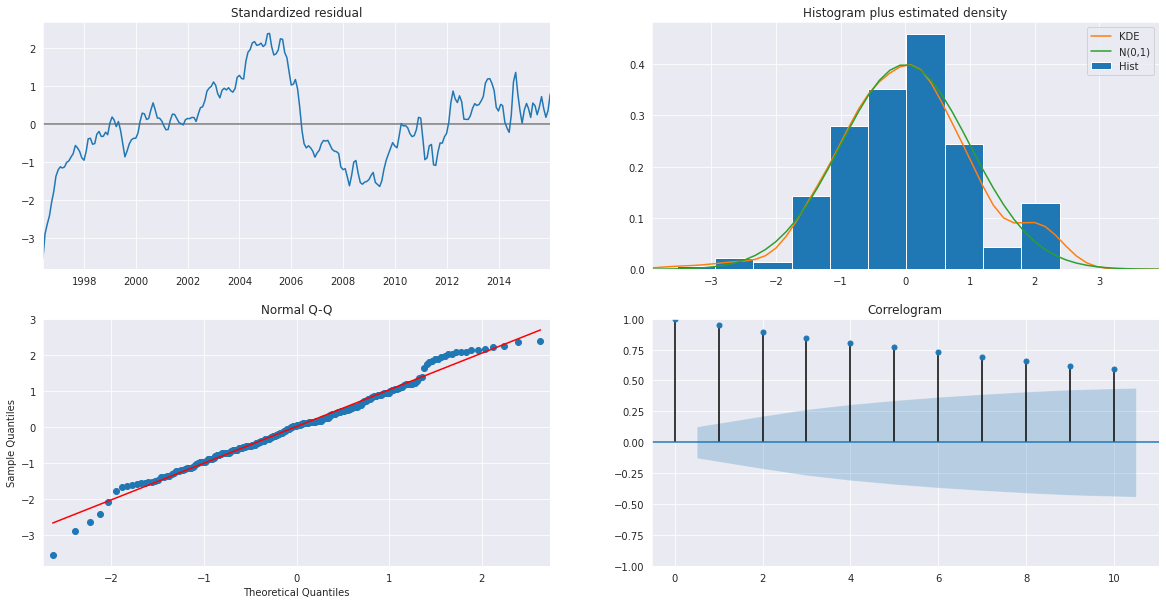

In [83]:
# Auto-ARIMA 

sarima_model =  auto_arima(Y_train, start_p=0, start_q=0,
                          max_p=7, max_d=2, max_q=7, # maximum p d q
                          seasonal=True,  # Seasonality
                          m=12,              # Seasonality type (Yearly)
                          max_P=7, max_D=2, max_Q=7, # maximum P D Q
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=42,information_criterion='aicc',
                          maxiter=50,
                          exogenous=X_train)
print(sarima_model.summary())
sarima_model.plot_diagnostics(figsize=(20, 10));

                               SARIMAX Results                                
Dep. Variable:                 Hawaii   No. Observations:                  237
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1822.466
Date:                Thu, 23 Feb 2023   AIC                           3652.932
Time:                        14:39:50   BIC                           3666.753
Sample:                    04-30-1996   HQIC                          3658.504
                         - 12-31-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     48.6017     54.271      0.896      0.371     -57.768     154.971
ar.L1          0.9756      0.015     64.954      0.000       0.946       1.005
ma.L1          0.2991      0.014     20.740      0.0

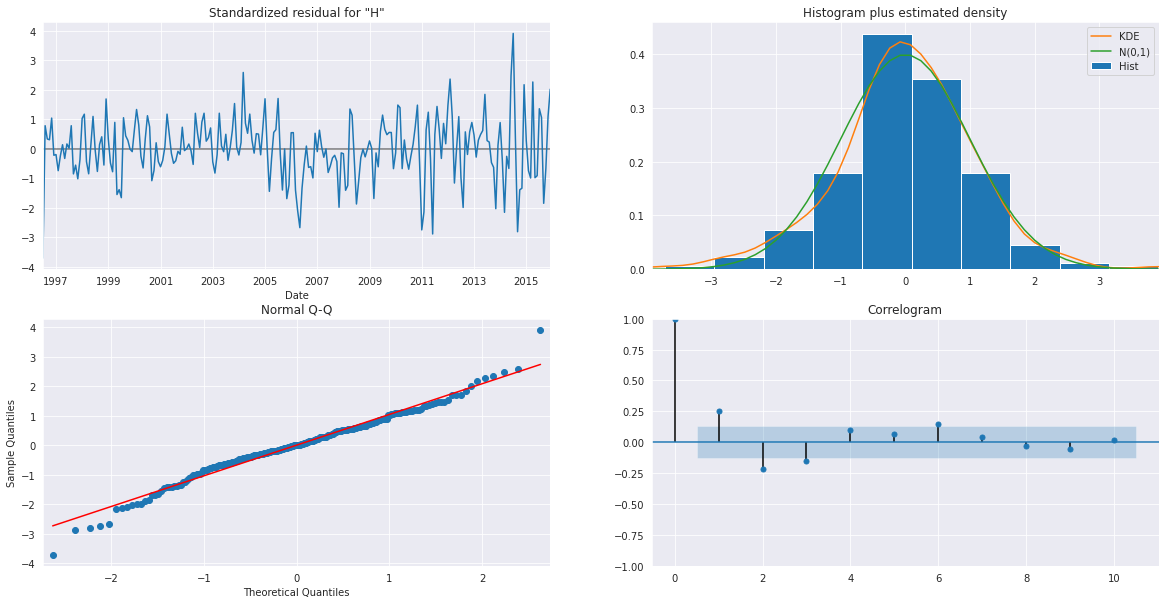

In [84]:
# Fit the model with the automatically selected parameters - ARIMA(1,1,1)(0,0,0)[12]
[p,d,q] = [1,1,1] # stepwise_model.order
[P,D,Q,S] = [0,0,0,12] # stepwise_model.seasonal_order
model_SARIMA_auto = SARIMAX(Y_train, 
                       order=(p,d,q), 
                       seasonal_order=(P,D,Q,S), 
                       enforce_stationarity=False,
                       enforce_invertibility=False, trend='c') # Auto-ARIMA idenfied a model with intercept as optimal, thus we include trend here 
result_SARIMA_auto = model_SARIMA_auto.fit()

# Verify the residuals
print(result_SARIMA_auto.summary()) 
result_SARIMA_auto.plot_diagnostics(figsize=(20, 10));

In [85]:
# Grid search to define the optimal ARIMA (p,d,q) parameters
AICc = np.zeros((36,3))
idx = 0 
d = 2 
for p in range(6):
  for q in range(6):
    mod = ARIMA(Y_train, order=(p,d,q)).fit()
    AICc[idx,0] = p
    AICc[idx,1] = q
    AICc[idx,2] = mod.aicc
    idx += 1 
    
order_df = pd.DataFrame(AICc, columns=['p', 'q', 'AICc'])
display(order_df)

# Best combination leading to the lowest AICc
opt = order_df[order_df['AICc']==order_df['AICc'].min()]
display(opt)
p_opt = opt['p']
q_opt = opt['q']

,p,q,AICc
0,0.0,0.0,3705.234792
1,0.0,1.0,3707.166359
2,0.0,2.0,3709.217992
3,0.0,3.0,3711.160111
4,0.0,4.0,3712.932228
5,0.0,5.0,3715.022687
6,1.0,0.0,3711.984718
7,1.0,1.0,3708.361485
8,1.0,2.0,3710.706478
9,1.0,3.0,3713.373771


,p,q,AICc
15,2.0,3.0,12.368421


                               SARIMAX Results                                
Dep. Variable:                 Hawaii   No. Observations:                  237
Model:                 ARIMA(2, 0, 3)   Log Likelihood               -1814.817
Date:                Thu, 23 Feb 2023   AIC                           3643.634
Time:                        14:40:45   BIC                           3667.910
Sample:                    04-30-1996   HQIC                          3653.419
                         - 12-31-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.875e+05    2.1e-08   1.85e+13      0.000    3.87e+05    3.87e+05
ar.L1          1.9824      0.013    153.980      0.000       1.957       2.008
ar.L2         -0.9831      0.013    -75.775      0.0

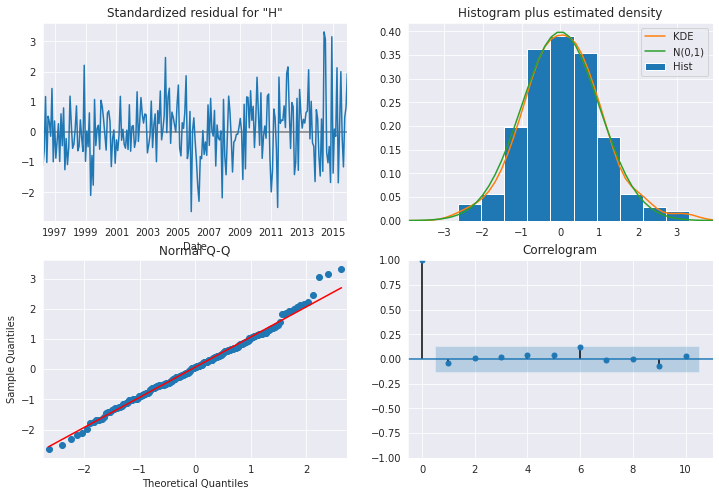

In [121]:
# Model estimation and diagnostic plots for residuals 
model_ARIMA = ARIMA(Y_train, order=(float(p_opt),0,float(q_opt))).fit()
print(model_ARIMA.summary())
model_ARIMA.plot_diagnostics(figsize=(12,8));

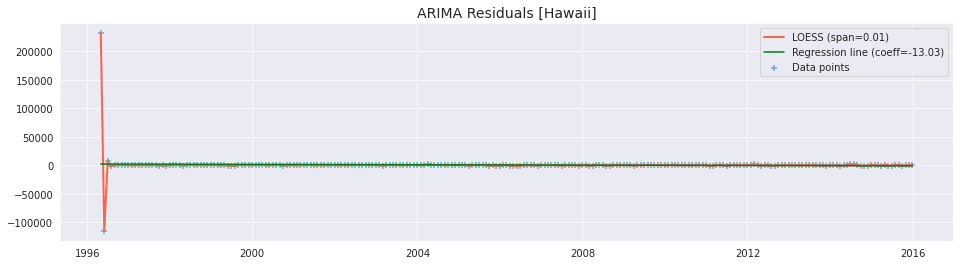

In [87]:
ARIMA_resid = pd.Series(result_SARIMA_auto.resid, index =Y_train.index)
plotTS(pd.DataFrame(ARIMA_resid, columns=['resid']), column='resid', figsize=(16,4), title='ARIMA Residuals [Hawaii]')

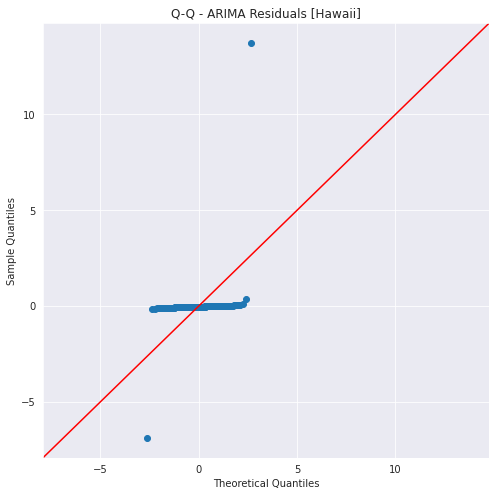

*** Shapiro-Wilk Test ***
W:  0.08933496475219727
p-value:  3.898251948824024e-32
Interpretation: the data was not drawn from a normal distribution (Ha)

*** Jarque-Bera Test ***
Jarque-Bera JB:  247436.78713616767
p-value:  0.0
Interpretation: the data was not drawn from a normal distribution (Ha)

*** D’Agostino-Pearson Test ***
k2:  429.66286749232177
p-value:  5.010646733454421e-94
Interpretation: the data was not drawn from a normal distribution (Ha)

----------------------------------------------------------------------
Skewness:  9.582550057375844
Kurtosis :  157.12921044212462


In [88]:
qqPlot(ARIMA_resid, title='- ARIMA Residuals [Hawaii]')
checkNormality(ARIMA_resid)

In [89]:
checkStationarity(ARIMA_resid, kpss_type='c')

*** ADF Test ***
ADF Statistic:  -6.59527613971745
p-value:  6.950665178056022e-09
Interpretation: The time series is stationary (Ha)

*** KPSS Test ***
KPSS Statistic: 0.2860799353062531
p-value:  0.1
Interpretation: The time series is stationary (Ho)


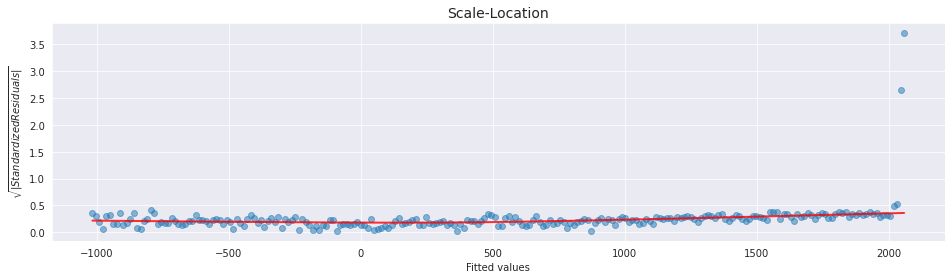

*** Koenker Test ***
Lagrange multiplier statistic:  4.456894258746589
p-value:  0.034760643268821514
Interpretation: Heteroscedasticity is present, the residuals are not distributed with equal variance (Ha)


In [90]:
scalelocationPlot(ARIMA_resid, figsize=(16,4))
checkHomoscedasticity(ARIMA_resid, robust=True)

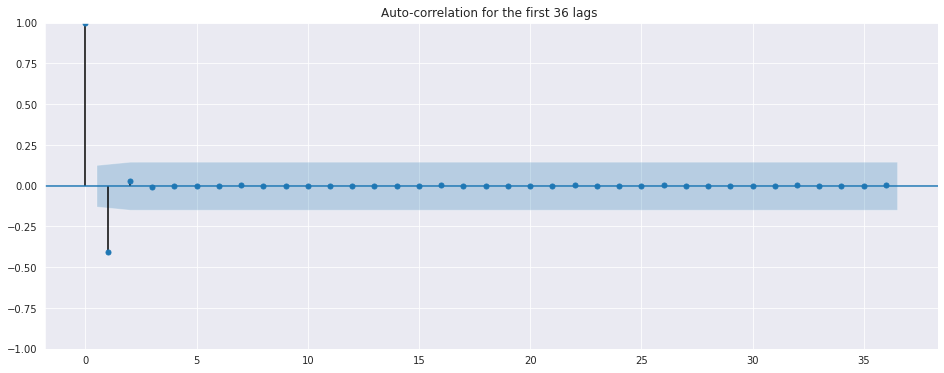

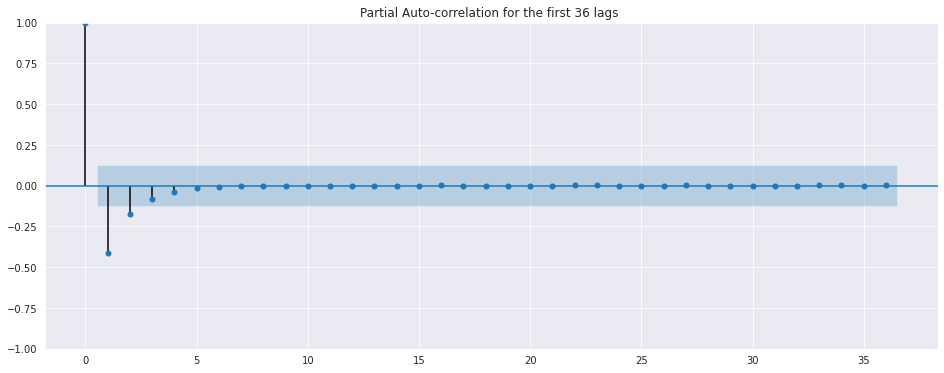

*** Ljung-Box Test [36 lags] ***
Q:  40.405471706091724
p-value:  0.2818659017944757
Interpretation: the residuals are independently distributed (Ho)

*** Breusch-Godfrey Test [36 lags] ***
Lagrange multiplier statistic:  46.50726244997987
p-value:  0.11278679438203817
Interpretation: there is no autocorrelation at any order less than or equal to p (Ho)


In [91]:
autocorrelationPlot(ARIMA_resid, lags=36)
checkAutorcorrelation(ARIMA_resid, lags=36)

In [92]:
y_pred_sarima = sarima_model.predict(n_periods=24, exogenous=X_test)
y_pred_sarima = pd.Series(y_pred_sarima)
y_pred_sarima.index = data_test.index

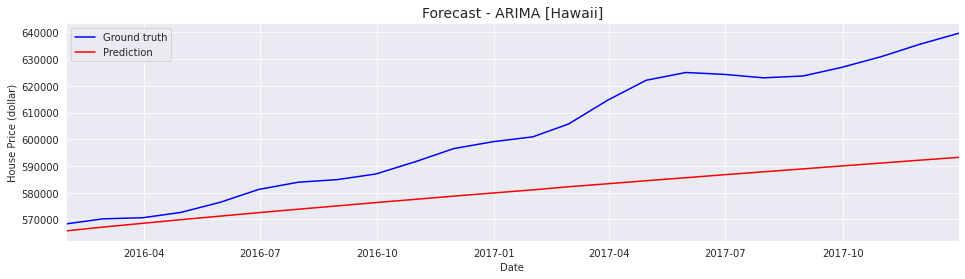

In [122]:
plt.figure(figsize=(16,4))
plt.plot(data_test, color='blue', label='Ground truth')
plt.plot(y_pred_sarima, color='red', label='Prediction')
plt.title('Forecast - ARIMA [Hawaii]', fontsize=14)
plt.xlim(data_test.index[0],data_test.index[-1])
plt.xlabel('Date')
plt.ylabel('House Price (dollar)')
plt.legend()
plt.show()

In [94]:
mse_arima = mean_squared_error(y_pred_sarima,data_test.values)
mae_arima = mean_absolute_error(y_pred_sarima,data_test.values)
mape_arima = mean_absolute_percentage_error(y_pred_sarima,data_test.values)*100

print('ARIMA model performance: ')
print('MSE: ', round(mse_arima,3))
print('MAE: ', round(mae_arima,3))
print('MAPE: ', round(mape_arima,3), '%')

ARIMA model performance: 
MSE:  711324335.144
MAE:  22163.423
MAPE:  3.786 %


#Prophet

In [95]:
from prophet import Prophet

In [96]:
train_prophet = pd.DataFrame({'y':data_train.values,'ds':data_train.index.to_list()})
prophet_model = Prophet(daily_seasonality=False, weekly_seasonality=False,yearly_seasonality=True)
prophet_fitted_model = prophet_model.fit(train_prophet)
future = prophet_fitted_model.make_future_dataframe(periods = 24)
forecast = prophet_fitted_model.predict(future)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxpbvoqwe/tzy23ibu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxpbvoqwe/ku5g8w04.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79663', 'data', 'file=/tmp/tmpxpbvoqwe/tzy23ibu.json', 'init=/tmp/tmpxpbvoqwe/ku5g8w04.json', 'output', 'file=/tmp/tmpxpbvoqwe/prophet_modelhlrijwhb/prophet_model-20230223144020.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:40:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:40:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


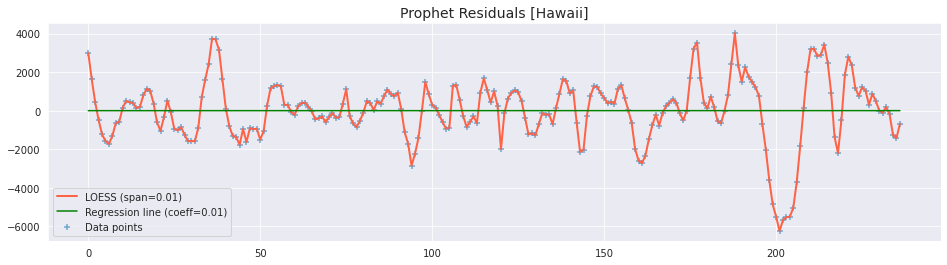

In [97]:
tmp = pd.merge(train_prophet, forecast.head(len(forecast)-24), on='ds')
prophet_resid = tmp['y'] - tmp['yhat']
plotTS(pd.DataFrame(prophet_resid, columns=['resid']), column='resid', figsize=(16,4), title='Prophet Residuals [Hawaii]')

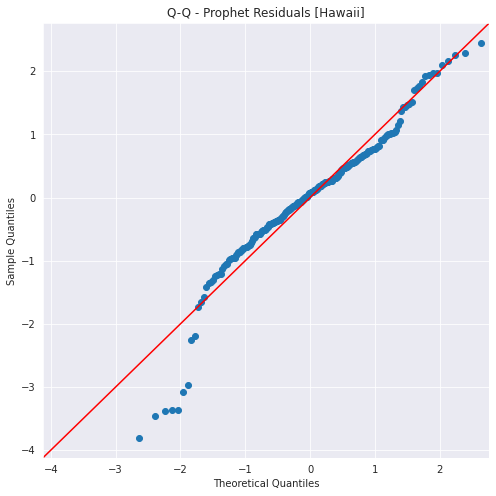

*** Shapiro-Wilk Test ***
W:  0.9419175386428833
p-value:  4.279174348198467e-08
Interpretation: the data was not drawn from a normal distribution (Ha)

*** Jarque-Bera Test ***
Jarque-Bera JB:  83.76404328493798
p-value:  0.0
Interpretation: the data was not drawn from a normal distribution (Ha)

*** D’Agostino-Pearson Test ***
k2:  38.72389367892477
p-value:  3.901335761657832e-09
Interpretation: the data was not drawn from a normal distribution (Ha)

----------------------------------------------------------------------
Skewness:  -0.788619256029286
Kurtosis :  2.4484185588070817


In [98]:
qqPlot(prophet_resid, title='- Prophet Residuals [Hawaii]')
checkNormality(prophet_resid)

In [99]:
checkStationarity(prophet_resid, kpss_type='c')

*** ADF Test ***
ADF Statistic:  -7.049426339943274
p-value:  5.576207696122708e-10
Interpretation: The time series is stationary (Ha)

*** KPSS Test ***
KPSS Statistic: 0.01907618219930251
p-value:  0.1
Interpretation: The time series is stationary (Ho)


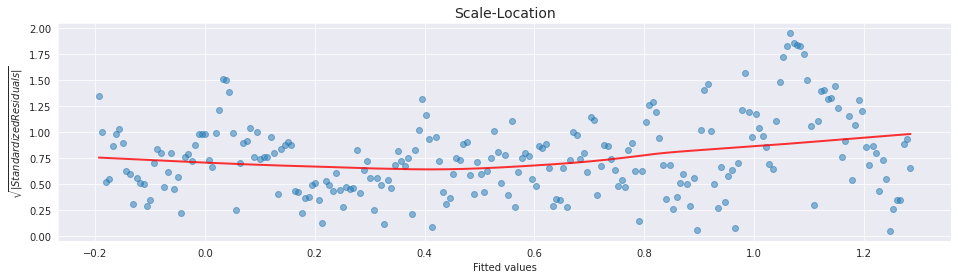

*** Koenker Test ***
Lagrange multiplier statistic:  18.729676813574848
p-value:  1.5062003402200965e-05
Interpretation: Heteroscedasticity is present, the residuals are not distributed with equal variance (Ha)


In [100]:
scalelocationPlot(prophet_resid, figsize=(16,4))
checkHomoscedasticity(prophet_resid, robust=True)

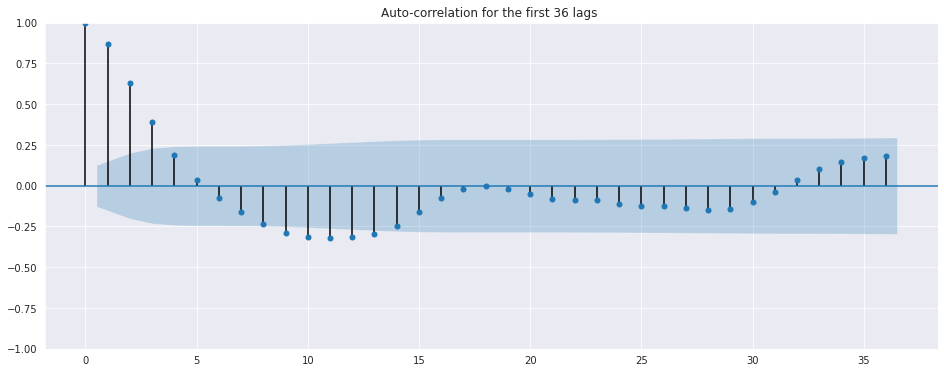

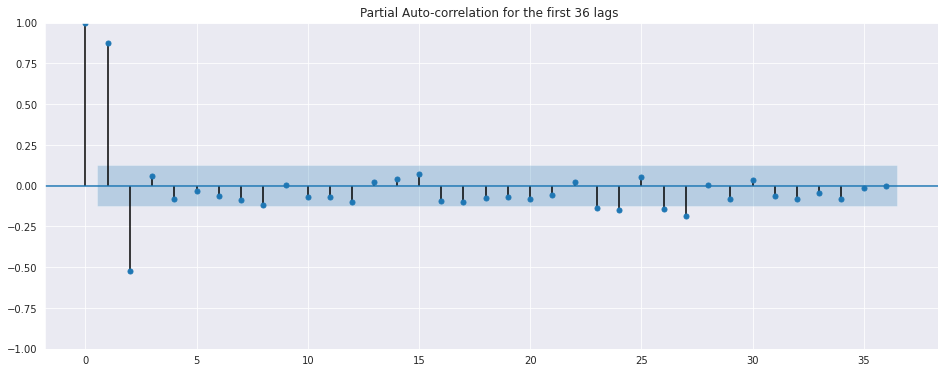

*** Ljung-Box Test [36 lags] ***
Q:  551.2908727607125
p-value:  1.7829524103276718e-93
Interpretation: The residuals are not independently distributed, they exhibit serial correlation (Ha)

*** Breusch-Godfrey Test [36 lags] ***
Lagrange multiplier statistic:  201.479107798104
p-value:  6.791193850585876e-25
Interpretation: There exists autocorrelation at some order less than or equal to p (Ha)


In [101]:
autocorrelationPlot(prophet_resid, lags=36)
checkAutorcorrelation(prophet_resid, lags=36)

In [102]:
y_pred_prophet = forecast['yhat'].tail(24)
y_pred_prophet.index = data_test.index

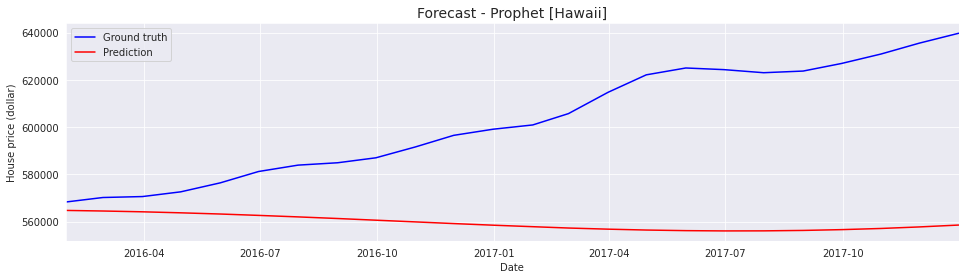

In [103]:
plt.figure(figsize=(16,4))
plt.plot(data_test, color='blue', label='Ground truth')
plt.plot(y_pred_prophet, color='red', label='Prediction')
plt.title('Forecast - Prophet [Hawaii]', fontsize=14)
plt.xlim(data_test.index[0],data_test.index[-1])
plt.xlabel('Date')
plt.ylabel('House price (dollar)')
plt.legend()
plt.show()

In [104]:
mse_prophet = mean_squared_error(y_pred_prophet,data_test.values)
mae_prophet = mean_absolute_error(y_pred_prophet,data_test.values)
mape_prophet = mean_absolute_percentage_error(y_pred_prophet,data_test.values)*100

print('Prophet model performance: ')
print('MSE: ', round(mse_prophet,3))
print('MAE: ', round(mae_prophet,3))
print('MAPE: ', round(mape_prophet,3), '%')

Prophet model performance: 
MSE:  2490138955.099
MAE:  42806.037
MAPE:  7.674 %


# Triple Exponential Smoothing (Holt-Winters method)

In [105]:
# Train and test 
data_train = Hawaii_ts[:-24]
data_test = Hawaii_ts[-24:]


In [106]:
# Triple Exponential Smoothing (Holt-Winters method)
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [107]:
# Fit = multiplicative trend, additive seasonal of period season_length = 36
holtwinters_fitted_model = ExponentialSmoothing(data_train.values,seasonal_periods=12,trend='add',seasonal='mul').fit()

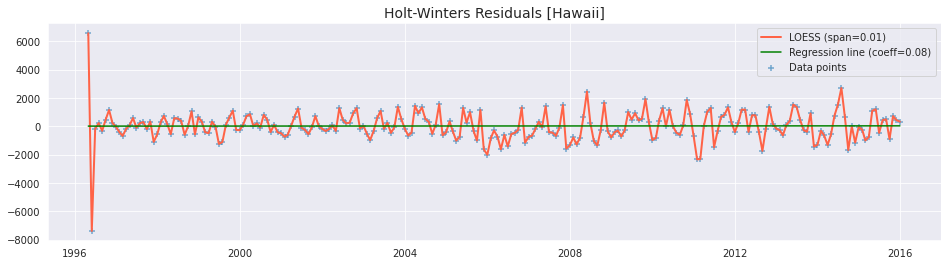

In [108]:
holtwinters_resid = pd.Series(holtwinters_fitted_model.resid, index =data_train.index)
plotTS(pd.DataFrame(holtwinters_resid, columns=['resid']), column='resid', figsize=(16,4), title='Holt-Winters Residuals [Hawaii]')

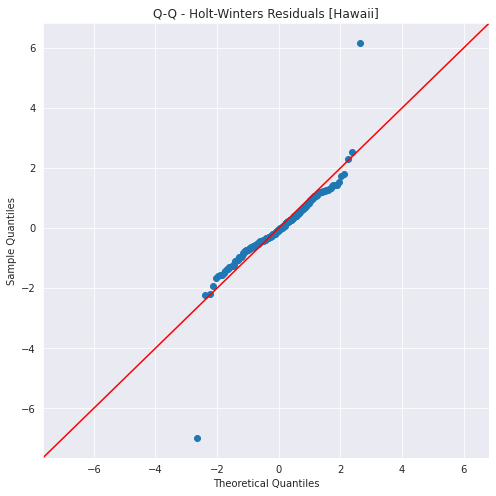

*** Shapiro-Wilk Test ***
W:  0.8619745969772339
p-value:  8.957994122957974e-14
Interpretation: the data was not drawn from a normal distribution (Ha)

*** Jarque-Bera Test ***
Jarque-Bera JB:  2081.415340454405
p-value:  0.0
Interpretation: the data was not drawn from a normal distribution (Ha)

*** D’Agostino-Pearson Test ***
k2:  71.3521690410503
p-value:  3.206810942238916e-16
Interpretation: the data was not drawn from a normal distribution (Ha)

----------------------------------------------------------------------
Skewness:  -0.3864721823561586
Kurtosis :  14.497544413351541


In [109]:
qqPlot(holtwinters_resid, title='- Holt-Winters Residuals [Hawaii]')
checkNormality(holtwinters_resid)

In [110]:
checkStationarity(holtwinters_resid, kpss_type='c')

*** ADF Test ***
ADF Statistic:  -3.2649750393074513
p-value:  0.01651855079864753
Interpretation: The time series is stationary (Ha)

*** KPSS Test ***
KPSS Statistic: 0.0776741297699286
p-value:  0.1
Interpretation: The time series is stationary (Ho)


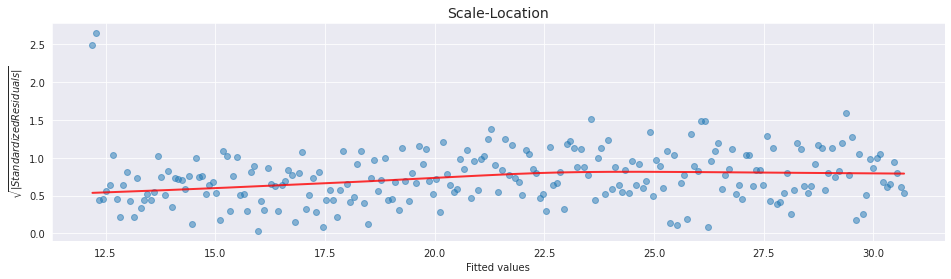

*** Koenker Test ***
Lagrange multiplier statistic:  2.1317151612221483
p-value:  0.14427923531035783
Interpretation: Homoscedasticity is present, the residuals are distributed with equal variance (Ho)


In [111]:
scalelocationPlot(holtwinters_resid, figsize=(16,4))
checkHomoscedasticity(holtwinters_resid, robust=True)

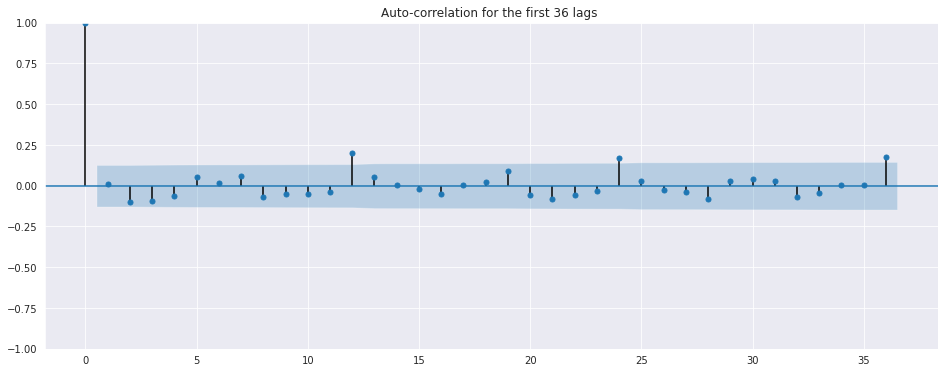

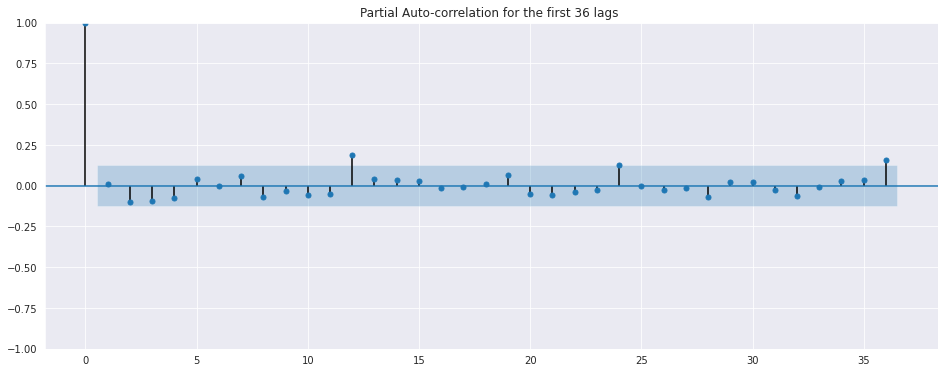

*** Ljung-Box Test [36 lags] ***
Q:  48.74788667020534
p-value:  0.07619935410535955
Interpretation: the residuals are independently distributed (Ho)

*** Breusch-Godfrey Test [36 lags] ***
Lagrange multiplier statistic:  30.808610668516422
p-value:  0.7137318144373703
Interpretation: there is no autocorrelation at any order less than or equal to p (Ho)


In [112]:
autocorrelationPlot(holtwinters_resid, lags=36)
checkAutorcorrelation(holtwinters_resid, lags=36)

In [113]:
# Predictions
y_pred_holtwinters = holtwinters_fitted_model.forecast(24)
y_pred_holtwinters = pd.Series(y_pred_holtwinters, index=data_test.index)

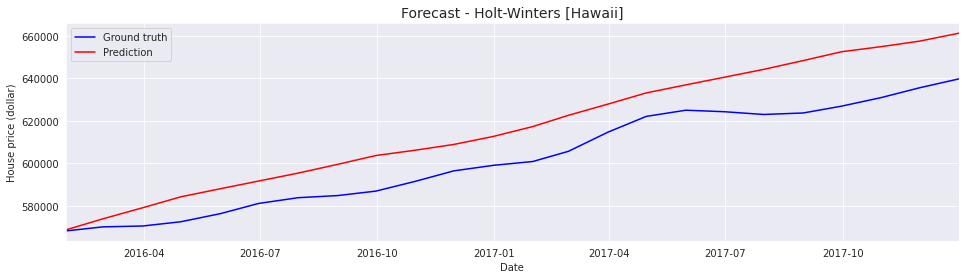

In [114]:
plt.figure(figsize=(16,4))
plt.plot(data_test, color='blue', label='Ground truth')
plt.plot(y_pred_holtwinters, color='red', label='Prediction')
plt.title('Forecast - Holt-Winters [Hawaii]', fontsize=14)
plt.xlim(data_test.index[0],data_test.index[-1])
plt.xlabel('Date')
plt.ylabel('House price (dollar)')
plt.legend()
plt.show()

In [115]:
mse_holtwinters = mean_squared_error(y_pred_holtwinters,data_test.values)
mae_holtwinters = mean_absolute_error(y_pred_holtwinters,data_test.values)
mape_holtwinters = mean_absolute_percentage_error(y_pred_holtwinters,data_test.values)*100

print('Holt-Winters model performance: ')
print('MSE: ', round(mse_holtwinters,3))
print('MAE: ', round(mae_holtwinters,3))
print('MAPE: ', round(mape_holtwinters,3), '%')

Holt-Winters model performance: 
MSE:  255303965.965
MAE:  14773.075
MAPE:  2.361 %


#Summery

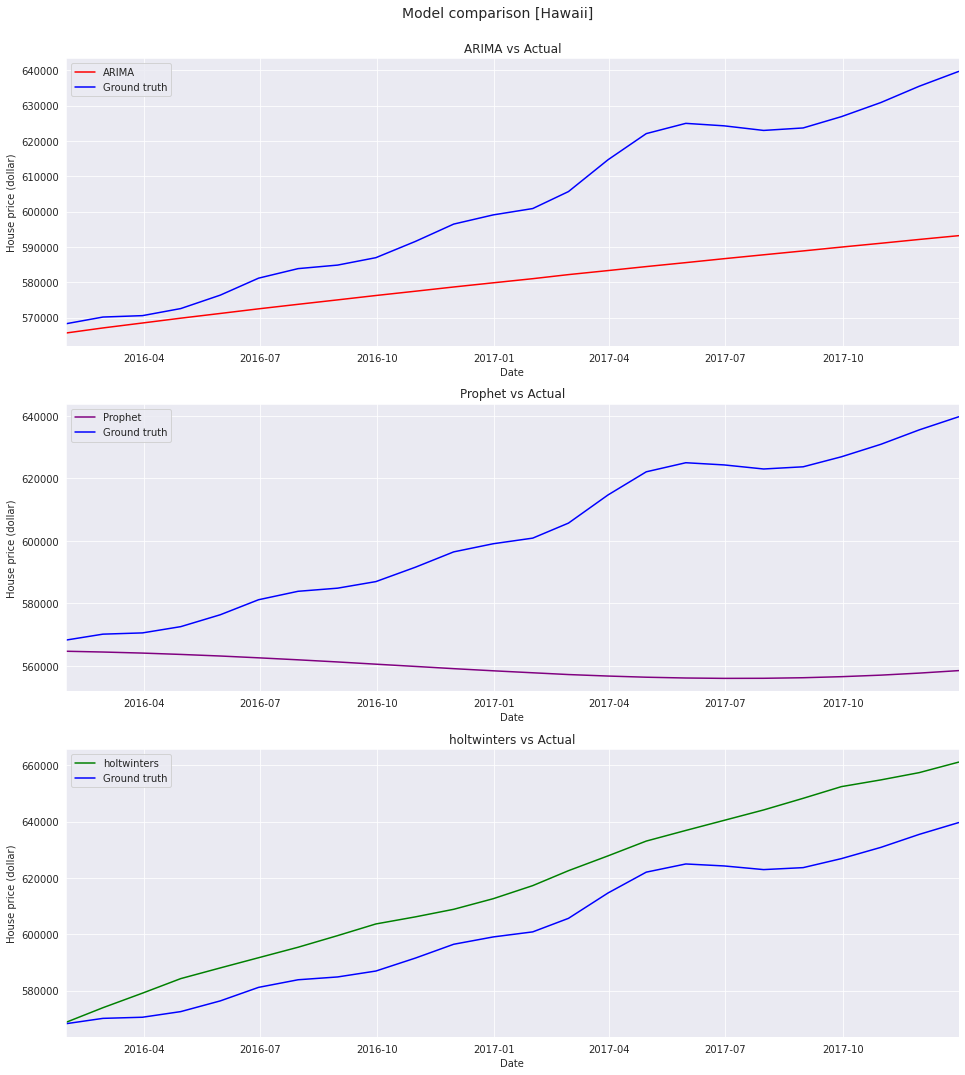

In [116]:
f, axes = plt.subplots(3,1,figsize=(16,18))
plt.suptitle('Model comparison [Hawaii]', y=0.92, fontsize=14)

axes[0].plot(y_pred_sarima, color='red', label='ARIMA')
axes[0].plot(data_test, color='blue', label='Ground truth')
axes[0].set_title('ARIMA vs Actual', fontdict={'fontsize': 12})

axes[1].plot(y_pred_prophet, color='purple', label='Prophet')
axes[1].plot(data_test, color='blue', label='Ground truth')
axes[1].set_title('Prophet vs Actual', fontdict={'fontsize': 12})

axes[2].plot(y_pred_holtwinters, color='green', label='holtwinters')
axes[2].plot(data_test, color='blue', label='Ground truth')
axes[2].set_title('holtwinters vs Actual', fontdict={'fontsize': 12})

for a in axes:
    a.set_ylabel('House price (dollar)')
    a.set_xlabel('Date')
    a.set_xlim(data_test.index[0], data_test.index[-1])
    a.legend()

plt.show()

In [117]:
data = {'Model':['ARIMA','PROPHET','HOLT WINTERS'],
        'MSE':[mse_arima, mse_prophet, mse_holtwinters],
        'MAE':[mae_arima, mae_prophet, mae_holtwinters],
        'MAPE (%)':[mape_arima, mape_prophet, mape_holtwinters],
        'Stationarity (residuals)':['Stationary','Stationary','Stationary'],
        'Distribution (residuals)':['Not normal','Not normal','Not normal'],
        'Homoscedasticity (residuals)':['Homoscedastic','Heteroscedastic','Homoscedastic'],
        'Autocorrelation (residuals)':['Not autocorrelated','Autocorrelated','Autocorrelated']}

all_models_summary = pd.DataFrame(data)
display(round(all_models_summary,3))

,Model,MSE,MAE,MAPE (%),Stationarity (residuals),Distribution (residuals),Homoscedasticity (residuals),Autocorrelation (residuals)
0,ARIMA,7.113243e+08,22163.423,3.786,Stationary,Not normal,Homoscedastic,Not autocorrelated
1,PROPHET,2.490139e+09,42806.037,7.674,Stationary,Not normal,Heteroscedastic,Autocorrelated
2,HOLT WINTERS,2.553040e+08,14773.075,2.361,Stationary,Not normal,Homoscedastic,Autocorrelated


#Forcasting

comapring the SARIMA model for 3 bed room houses for hawaii, Alabama and NewJersey, Oklahoma, Michigan

**SARIMA** **Model**

In [ ]:
#SARIMA Model
house3b_price_han = ['Hawaii','Alabama','NewJersey','Oklahoma','Michigan']
for state in house3b_price_han:

    #train-test split
    train = house3b_price_states[state][:-24] 
    test = house3b_price_states[state][-24:]

    #model training and prediction
    AICc = np.zeros((36,3))
    idx = 0 
    d = 2 
    for p in range(6):
      for q in range(6):
        mod = ARIMA(train, order=(p,d,q)).fit()
        AICc[idx,0] = p
        AICc[idx,1] = q
        AICc[idx,2] = mod.aicc
        idx += 1 
        order_df = pd.DataFrame(AICc, columns=['p', 'q', 'AICc'])

    # Best combination leading to the lowest AICc
    opt = order_df[order_df['AICc']==order_df['AICc'].min()]
    p_opt = opt['p']
    q_opt = opt['q']
    model_ARIMA = ARIMA(train, order=(float(p_opt),0,float(q_opt))).fit()
    y_pred_arima = model_ARIMA.predict(n_periods=24)
    y_pred_arima = pd.Series(y_pred_arima)
    #y_pred_arima.index = test.index

    #prediction plot
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue', label='Ground truth')
    plt.plot(y_pred_arima, color='red', label='Prediction')
    plt.title('Forecast - SARIMA [{}]'.format(state), fontsize=14)
    plt.xlim(test.index[0],test.index[-1])
    plt.xlabel('Date')
    plt.ylabel('Price of 3bedroom house (dollar)')
    plt.legend()
    plt.show()
    
    #model performance
    #mse_sarima = mean_squared_error(y_pred_arima,test.values)
    #mae_sarima = mean_absolute_error(y_pred_arima,test.values)
    #mape_sarima = mean_absolute_percentage_error(y_pred_arima,test.values)*100

    #print('SARIMA model performance: ')
    #print('MSE: ', round(mse_sarima,3))
    #print('MAE: ', round(mae_sarima,3))
    #print('MAPE: ', round(mape_sarima,3), '%')

**PROPHET Model**

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxpbvoqwe/gv6yut6i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxpbvoqwe/tibbrxr6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24861', 'data', 'file=/tmp/tmpxpbvoqwe/gv6yut6i.json', 'init=/tmp/tmpxpbvoqwe/tibbrxr6.json', 'output', 'file=/tmp/tmpxpbvoqwe/prophet_modelpscu8quw/prophet_model-20230223144035.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:40:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:40:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


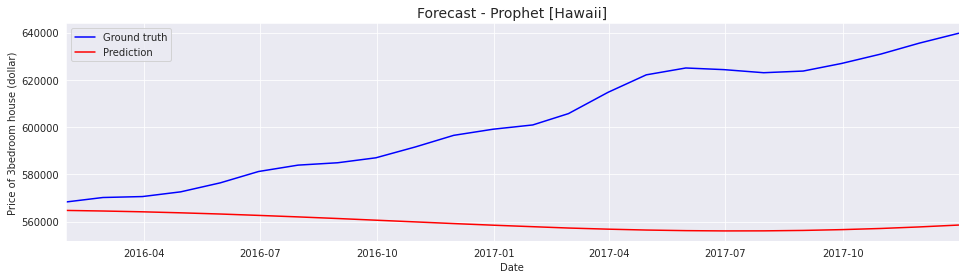

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxpbvoqwe/dsgqsfaa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxpbvoqwe/7eiptot7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26070', 'data', 'file=/tmp/tmpxpbvoqwe/dsgqsfaa.json', 'init=/tmp/tmpxpbvoqwe/7eiptot7.json', 'output', 'file=/tmp/tmpxpbvoqwe/prophet_model4tqsvg4f/prophet_model-20230223144036.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:40:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Prophet model performance: 
MSE:  2490138955.099
MAE:  42806.037
MAPE:  7.674 %


14:40:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


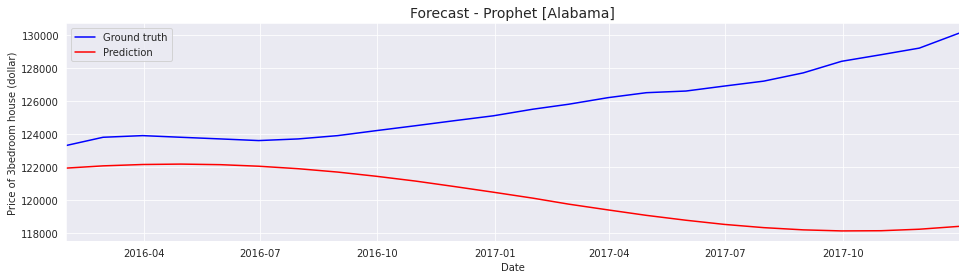

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxpbvoqwe/xaq0a68v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxpbvoqwe/0dt9vdir.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66849', 'data', 'file=/tmp/tmpxpbvoqwe/xaq0a68v.json', 'init=/tmp/tmpxpbvoqwe/0dt9vdir.json', 'output', 'file=/tmp/tmpxpbvoqwe/prophet_model0f_d06_s/prophet_model-20230223144037.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:40:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Prophet model performance: 
MSE:  42641145.218
MAE:  5506.477
MAPE:  4.619 %


14:40:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


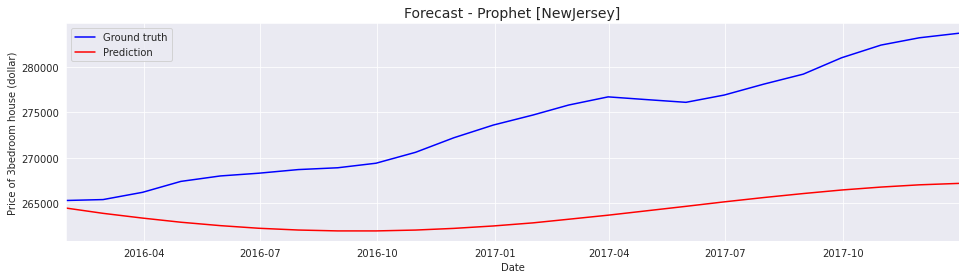

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxpbvoqwe/lx6_boq_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxpbvoqwe/y995wbva.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69966', 'data', 'file=/tmp/tmpxpbvoqwe/lx6_boq_.json', 'init=/tmp/tmpxpbvoqwe/y995wbva.json', 'output', 'file=/tmp/tmpxpbvoqwe/prophet_modelg88um58f/prophet_model-20230223144037.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:40:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Prophet model performance: 
MSE:  114458795.744
MAE:  9717.955
MAPE:  3.675 %


14:40:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


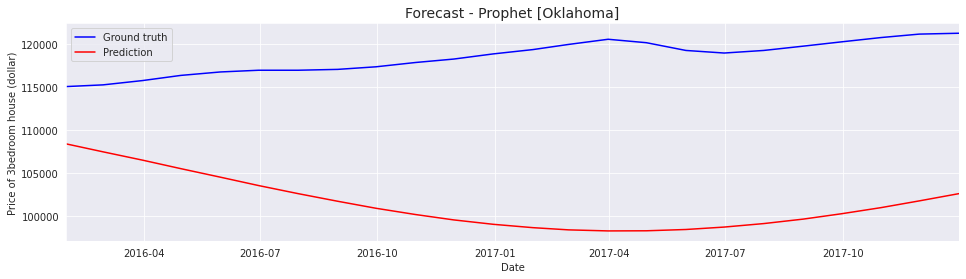

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxpbvoqwe/ev2wubrb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxpbvoqwe/3mu3_ow9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70485', 'data', 'file=/tmp/tmpxpbvoqwe/ev2wubrb.json', 'init=/tmp/tmpxpbvoqwe/3mu3_ow9.json', 'output', 'file=/tmp/tmpxpbvoqwe/prophet_modelnxgnw58l/prophet_model-20230223144038.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:40:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Prophet model performance: 
MSE:  309767935.165
MAE:  16995.527
MAPE:  16.882 %


14:40:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


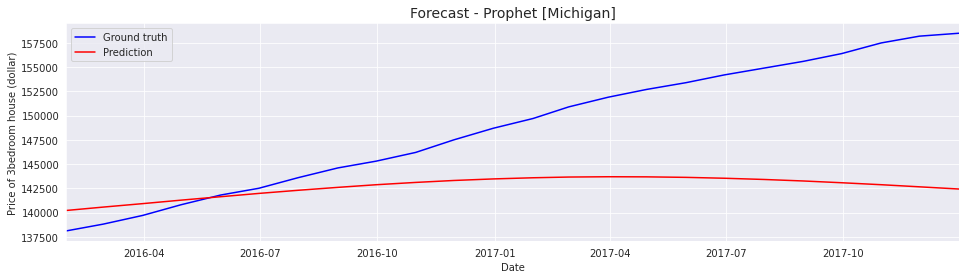

Prophet model performance: 
MSE:  70834815.811
MAE:  6623.967
MAPE:  4.63 %


In [119]:
#Hawaii_ts and Alabama_ts and NewJersey_ts
house3b_price_han = ['Hawaii','Alabama','NewJersey','Oklahoma','Michigan']
for state in house3b_price_han:
    #train-test split
    train = house3b_price_states[state][:-24] 
    test = house3b_price_states[state][-24:]

    #model training and prediction
    train_prophet = pd.DataFrame({'y':train.values,'ds':data_train.index.to_list()})
    prophet_model = Prophet(daily_seasonality=False, weekly_seasonality=False,yearly_seasonality=True)
    prophet_fitted_model = prophet_model.fit(train_prophet)
    future = prophet_fitted_model.make_future_dataframe(periods = 24)
    forecast = prophet_fitted_model.predict(future)
    y_pred_prophet = forecast['yhat'].tail(24)
    y_pred_prophet.index = test.index

    #prediction plot
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue', label='Ground truth')
    plt.plot(y_pred_prophet, color='red', label='Prediction')
    plt.title('Forecast - Prophet [{}]'.format(state), fontsize=14)
    plt.xlim(test.index[0],test.index[-1])
    plt.xlabel('Date')
    plt.ylabel('Price of 3bedroom house (dollar)')
    plt.legend()
    plt.show()
    
    #model performance
    mse_prophet = mean_squared_error(y_pred_prophet,test.values)
    mae_prophet = mean_absolute_error(y_pred_prophet,test.values)
    mape_prophet = mean_absolute_percentage_error(y_pred_prophet,test.values)*100

    print('Prophet model performance: ')
    print('MSE: ', round(mse_prophet,3))
    print('MAE: ', round(mae_prophet,3))
    print('MAPE: ', round(mape_prophet,3), '%')

**TES  Model-Holt Winter Method**

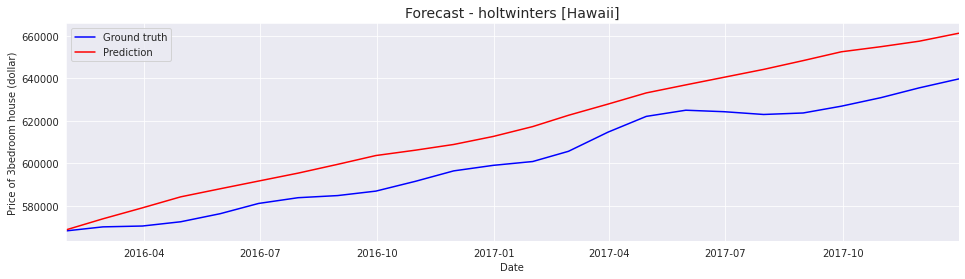

Holt-Winters model performance: 
MSE:  255303965.965
MAE:  14773.075
MAPE:  2.361 %


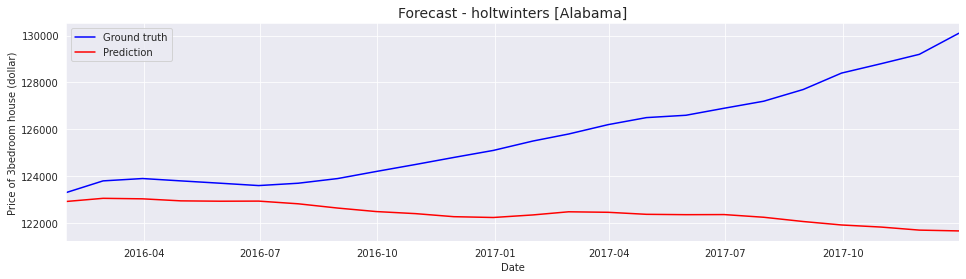

Holt-Winters model performance: 
MSE:  230789579219.572
MAE:  479841.468
MAPE:  391.968 %


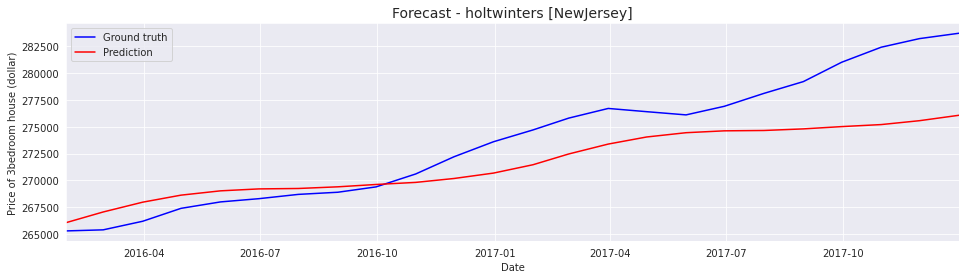

Holt-Winters model performance: 
MSE:  109741398095.93
MAE:  330669.925
MAPE:  121.68 %


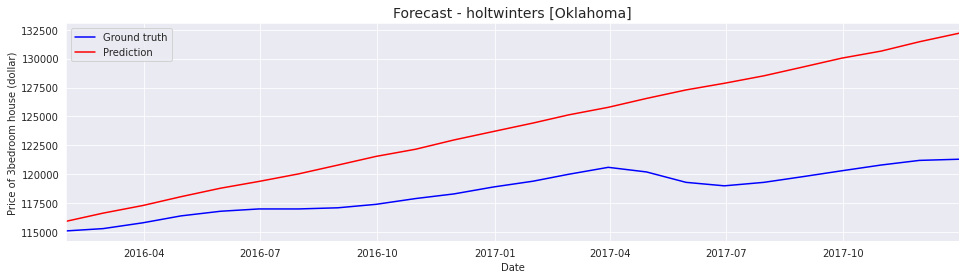

Holt-Winters model performance: 
MSE:  229056420541.326
MAE:  478256.8
MAPE:  385.655 %


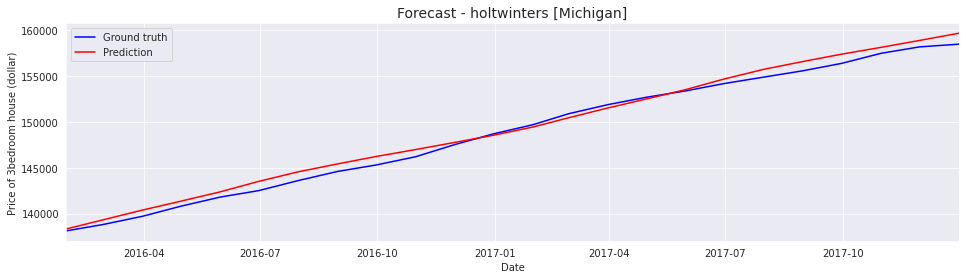

Holt-Winters model performance: 
MSE:  205455226155.652
MAE:  452969.636
MAPE:  303.477 %


In [120]:
#Hawaii_ts and Alabama_ts and NewJersey_ts
house3b_price_han = ['Hawaii','Alabama','NewJersey','Oklahoma','Michigan']
for state in house3b_price_han:
    #train-test split
    train = house3b_price_states[state][:-24] 
    test = house3b_price_states[state][-24:]

    #model training and prediction
    holtwinters_fitted_model = ExponentialSmoothing(train.values,seasonal_periods=12,trend='add',seasonal='mul').fit()
    y_pred_holtwinters = holtwinters_fitted_model.forecast(24)
    y_pred_holtwinters = pd.Series(y_pred_holtwinters, index=test.index)

    #prediction plot
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue', label='Ground truth')
    plt.plot(y_pred_holtwinters, color='red', label='Prediction')
    plt.title('Forecast - holtwinters [{}]'.format(state), fontsize=14)
    plt.xlim(test.index[0],test.index[-1])
    plt.xlabel('Date')
    plt.ylabel('Price of 3bedroom house (dollar)')
    plt.legend()
    plt.show()
    
    #model performance
    mse_holtwinters = mean_squared_error(y_pred_holtwinters,data_test.values)
    mae_holtwinters = mean_absolute_error(y_pred_holtwinters,data_test.values)
    mape_holtwinters = mean_absolute_percentage_error(y_pred_holtwinters,data_test.values)*100

    print('Holt-Winters model performance: ')
    print('MSE: ', round(mse_holtwinters,3))
    print('MAE: ', round(mae_holtwinters,3))
    print('MAPE: ', round(mape_holtwinters,3), '%')